In [1]:
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split

def extract_mfcc(file_path, n_mfcc=13, n_fft=1024, hop_length=512, sr=16000):
    # Load audio file
    y, sr = librosa.load(file_path, sr=sr)  # Load with the specified sampling rate
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    # Mean normalization across time
    mfccs = np.mean(mfccs, axis=1)
    return mfccs

def load_data(directory, label):
    features = []
    # Load all files from the directory and extract features
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            file_path = os.path.join(directory, filename)
            mfccs = extract_mfcc(file_path)
            features.append(mfccs)
    return features, [label] * len(features)

# Load wake word and non-wake word samples
wake_word_features, wake_word_labels = load_data('ww_16/', 1)
non_wake_word_features, non_wake_word_labels = load_data('nww_16/', 0)

# Combine the datasets
features = np.array(wake_word_features + non_wake_word_features)
labels = np.array(wake_word_labels + non_wake_word_labels)

# Split the data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Optionally, save the split data
np.savez('processed_audio_data.npz', X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

print("Data processing complete. Data split into training, validation, and testing sets.")


Data processing complete. Data split into training, validation, and testing sets.


In [2]:
print(f"X-train: {X_train.shape}, y-train: {y_train.shape}")
print(f"X-test: {X_test.shape}, y-test: {y_test.shape}")
print(f"X-val: {X_val.shape}, y-val: {y_val.shape}")

X-train: (180, 13), y-train: (180,)
X-test: (60, 13), y-test: (60,)
X-val: (60, 13), y-val: (60,)


wake word MFCC spectrocopy


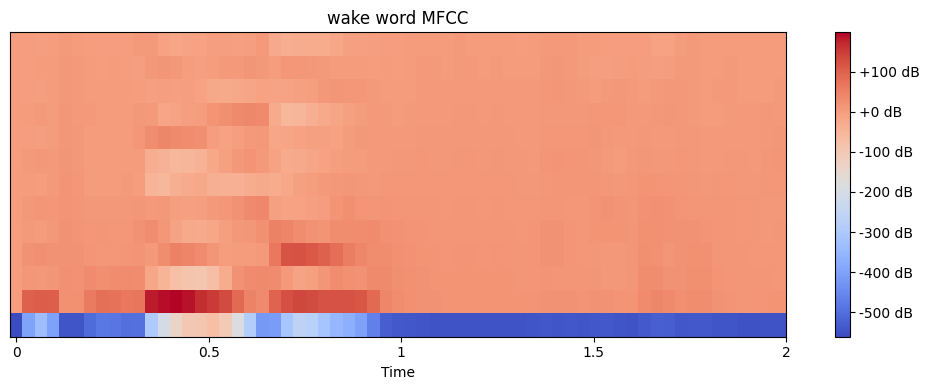

Non wake word MFCC spectroscopy


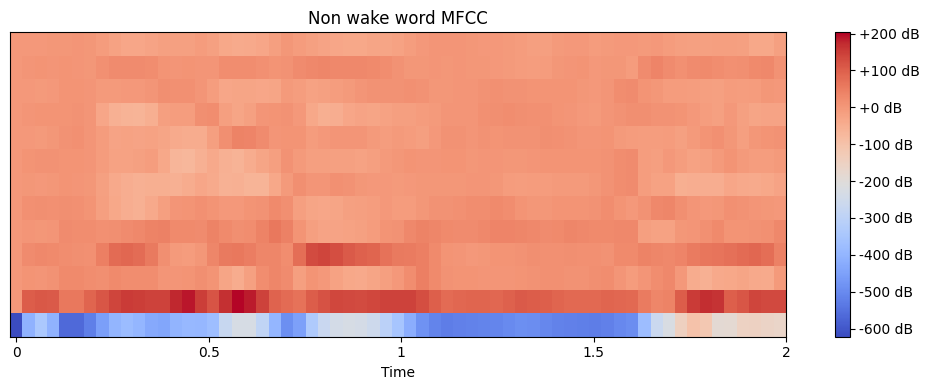

In [3]:
## Extracting MFCC spectrogram

import matplotlib.pyplot as plt
def extract_full_mfcc(file_path, n_mfcc=13, n_fft=2048, hop_length=512, sr=16000):
    # Load audio file
    y, sr = librosa.load(file_path, sr=sr)
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfccs
    
def plot_mfcc(mfccs, sr=16000, hop_length=512,title='default MFCC'):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

sample_non_wake_word_features=extract_full_mfcc("nww_16\\random_speech_12.wav")
sample_wake_word_features = extract_full_mfcc("ww_16\\raspi_10.wav")

print("wake word MFCC spectrocopy")
plot_mfcc(sample_wake_word_features,title="wake word MFCC")

print("Non wake word MFCC spectroscopy")
plot_mfcc(sample_non_wake_word_features,title="Non wake word MFCC")

#print(features[10],labels[10]) ## Wake word features
#print(features[20],labels[20]) ## Wake word features
#print(features[150],labels[150]) ## Non-wake word features




In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch
'''
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Using LSTM instead of RNN
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states
        # (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # LSTM returns output and (hn, cn)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out.squeeze()

#model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
'''

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        
        # Pass the output of the last time step
        out = self.fc(out[:, -1, :]).squeeze()
        return out


def train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        with torch.no_grad():  # Turn off gradients for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        model.train() 


In [89]:
        
# Parameters
input_size = 13  # Number of MFCC features
hidden_size = 64  # Number of features in the hidden state
num_layers = 1  # One layer
num_classes = 1  # Binary classification

# Assuming X_train and y_train are your data arrays loaded from previous steps
X_train_tensor = torch.tensor(X_train).float().unsqueeze(1)  # Add sequence dimension
y_train_tensor = torch.tensor(y_train).float()

X_test_tensor = torch.tensor(X_test).float().unsqueeze(1)  # Add sequence dimension
y_test_tensor = torch.tensor(y_test).float()

X_val_tensor = torch.tensor(X_val).float().unsqueeze(1)  # Add sequence dimension
y_val_tensor = torch.tensor(y_val).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

In [90]:
print(f'{X_train_tensor.shape},{y_train_tensor.shape}')

torch.Size([180, 1, 13]),torch.Size([180])


In [91]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = RNNModel(input_size, hidden_size, num_layers, num_classes)#.to(device)
#model = RNNModel(input_size, hidden_size, num_layers, num_classes)#.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=100)

Epoch [1/100], Train Loss: 0.7265, Validation Loss: 0.6842
Epoch [2/100], Train Loss: 0.6673, Validation Loss: 0.6630
Epoch [3/100], Train Loss: 0.6486, Validation Loss: 0.6513
Epoch [4/100], Train Loss: 0.6348, Validation Loss: 0.6466
Epoch [5/100], Train Loss: 0.6209, Validation Loss: 0.6479
Epoch [6/100], Train Loss: 0.6219, Validation Loss: 0.6502
Epoch [7/100], Train Loss: 0.6257, Validation Loss: 0.6503
Epoch [8/100], Train Loss: 0.6184, Validation Loss: 0.6479
Epoch [9/100], Train Loss: 0.6177, Validation Loss: 0.6455
Epoch [10/100], Train Loss: 0.6183, Validation Loss: 0.6428
Epoch [11/100], Train Loss: 0.6163, Validation Loss: 0.6382
Epoch [12/100], Train Loss: 0.6109, Validation Loss: 0.6349
Epoch [13/100], Train Loss: 0.6058, Validation Loss: 0.6331
Epoch [14/100], Train Loss: 0.6053, Validation Loss: 0.6296
Epoch [15/100], Train Loss: 0.6027, Validation Loss: 0.6253
Epoch [16/100], Train Loss: 0.5975, Validation Loss: 0.6211
Epoch [17/100], Train Loss: 0.5981, Validation Lo

In [92]:
torch.save(model.state_dict(),'RNN_wake_word.pth')

In [93]:
model=RNNModel(13,64,1,1)
model.load_state_dict(torch.load('RNN_wake_word.pth'))

<All keys matched successfully>

In [94]:
total_loss = 0
correct_predictions = 0
total_predictions = 0

model.eval()

with torch.no_grad():
    for data in test_loader:
        inputs,labels = data
        outputs= model(inputs)
        predicted_labels = torch.sigmoid(outputs).squeeze() > 0.5
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

accuracy = 100 * correct_predictions/total_predictions
print(f'Accuracy: {accuracy}%')

Accuracy: 93.33333333333333%


In [23]:
def evaluate_model(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()

            # Convert output probabilities to predicted class (0 or 1)
            predicted_labels = torch.sigmoid(outputs).squeeze() > 0.5
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions * 100
    return avg_loss, accuracy

In [25]:
test_loss, test_accuracy = evaluate_model(model, device, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.3380, Test Accuracy: 85.00%


In [95]:
import numpy as np
import sounddevice as sd
import librosa


sr = 16000  # Sample rate in Hz
duration = 2         
n_mfcc = 13
n_fft = 1024
hop_length = 512

buffer_size = sr*duration

audio_buffer= np.zeros(buffer_size,dtype=np.float32)
buffer_index=0
model.eval()

def audio_callback(intdata,frames,time,status):
    global audio_buffer
    #print("Entered")
    if status:
        print("Error: ",status)

    audio_buffer = np.roll(audio_buffer, -len(intdata))
    audio_buffer[-len(intdata):] = intdata[:, 0]
    #print(len(audio_buffer))
    if(len(audio_buffer)>= buffer_size):
        mfccs = librosa.feature.mfcc(y=audio_buffer, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfccs = np.mean(mfccs, axis=1)
        feature=torch.tensor([mfccs]).float().unsqueeze(0)
        with torch.no_grad():
            output=model(feature)
            predicted_prob = torch.sigmoid(output).item()
            print(f"{predicted_prob}")
                
with sd.InputStream(callback=audio_callback, channels=1, samplerate=sr, dtype=np.float32):
    print("Listening... Press Ctrl+C to stop.")
    try:
        while True:
            sd.sleep(500)
    except KeyboardInterrupt:
        print("Stopped listening.")

Listening... Press Ctrl+C to stop.
0.5656247138977051
0.5621803998947144
0.5466559529304504
0.5473486185073853
0.5498073697090149
0.5391432046890259
0.5339834094047546
0.5382286906242371
0.5572158098220825
0.5502477884292603
0.5484023690223694
0.5506430268287659
0.566558301448822
0.5569018125534058
0.5517623424530029
0.5544006824493408
0.5621793270111084
0.5558083653450012
0.5512331128120422
0.5684225559234619
0.5572105050086975
0.5591436624526978
0.5556583404541016
0.5667285919189453
0.5550135374069214
0.5478445887565613
0.5586254596710205
0.5532429814338684
0.5572410225868225
0.5684547424316406
0.5736429691314697
0.5652818083763123
0.57684326171875
0.5847166776657104
0.5876715183258057
0.5783990621566772
0.5856655836105347
0.5891797542572021
0.594678521156311
0.5983149409294128
0.6017776131629944
0.6010108590126038
0.5936598777770996
0.5972529649734497
0.5932239890098572
0.5980731248855591
0.5899503827095032
0.6039121747016907
0.5996211767196655
0.6028770208358765
0.6000586748123169


0.2212374210357666
0.21648043394088745
0.20877450704574585
0.21273726224899292
0.23093996942043304
0.21976496279239655
0.214447021484375
0.2247166484594345
0.23725588619709015
0.22523854672908783
0.213518887758255
0.24420398473739624
0.24426604807376862
0.23221060633659363
0.22514376044273376
0.22801735997200012
0.2541189193725586
0.2307378649711609
0.2159506380558014
0.22940018773078918
0.2502248287200928
0.2419724464416504
0.2295519858598709
0.24734953045845032
0.2512916922569275
0.24666276574134827
0.24394632875919342
0.26318982243537903
0.2563454806804657
0.24471953511238098
0.2462550401687622
0.26237714290618896
0.2586700916290283
0.23659349977970123
0.2519643306732178
0.2592844069004059
0.24879233539104462
0.23581252992153168
0.2596980929374695
0.2579801082611084
0.23178856074810028
0.25253280997276306
0.2670506238937378
0.2561010420322418
0.2511019706726074
0.2604312300682068
0.2678842544555664
0.24365174770355225
0.23512543737888336
0.2562706470489502
0.2544781565666199
0.23853

0.18003930151462555
0.1616809070110321
0.18740670382976532
0.18690429627895355
0.172349750995636
0.18643365800380707
0.1893937736749649
0.17717306315898895
0.1669728308916092
0.1828242540359497
0.18919333815574646
0.16967828571796417
0.1669781357049942
0.18829257786273956
0.18731209635734558
0.16365572810173035
0.16803547739982605
0.1856192648410797
0.17901192605495453
0.15569797158241272
0.16745822131633759
0.1754743456840515
0.17489942908287048
0.1578540802001953
0.17639879882335663
0.17434075474739075
0.15478257834911346
0.15930263698101044
0.16645316779613495
0.15610988438129425
0.1469404250383377
0.16689425706863403
0.16515424847602844
0.14768445491790771
0.1427721083164215
0.15687569975852966
0.15033966302871704
0.13819624483585358
0.13998281955718994
0.1677846759557724
0.14868450164794922
0.13679814338684082
0.14498500525951385
0.1632467806339264
0.14329680800437927
0.1395299732685089
0.1566457897424698
0.1629635989665985
0.14552614092826843
0.13259337842464447
0.157234102487564

0.23226410150527954
0.239702507853508
0.2553730309009552
0.24133966863155365
0.24436478316783905
0.2526131570339203
0.2519286572933197
0.2416536659002304
0.24566756188869476
0.26405632495880127
0.252056360244751
0.24800463020801544
0.27513575553894043
0.26691120862960815
0.2540784776210785
0.25741854310035706
0.27175071835517883
0.2803632318973541
0.24651236832141876
0.2571398913860321
0.2794989347457886
0.2578139305114746
0.24789145588874817
0.2630929946899414
0.2729640603065491
0.2552620768547058
0.26828712224960327
0.2555638253688812
0.254692018032074
0.2411055564880371
0.2521342933177948
0.2537396252155304
0.24888372421264648
0.24170461297035217
0.24462641775608063
0.2486124038696289
0.24027147889137268
0.2418864369392395
0.2465963512659073
0.2551819086074829
0.24631519615650177
0.25158560276031494
0.25758081674575806
0.2591039538383484
0.2537548542022705
0.25677239894866943
0.2659434676170349
0.27181434631347656
0.25857266783714294
0.25641724467277527
0.26536762714385986
0.2681172

0.22001013159751892
0.23610328137874603
0.21863584220409393
0.19045977294445038
0.22425322234630585
0.23235656321048737
0.20387513935565948
0.20014098286628723
0.22877958416938782
0.22880412638187408
0.1931663602590561
0.20278888940811157
0.22954235970973969
0.20998309552669525
0.18387962877750397
0.20315143465995789
0.22467952966690063
0.19581767916679382
0.1926688253879547
0.22247637808322906
0.21557438373565674
0.18673303723335266
0.19738760590553284
0.21262066066265106
0.23172688484191895
0.19785800576210022
0.23068608343601227
0.22631707787513733
0.2098916918039322
0.19844262301921844
0.2318340241909027
0.2180987447500229
0.19768354296684265
0.20287278294563293
0.21920548379421234
0.21370592713356018
0.19188761711120605
0.2006189376115799
0.2234220951795578
0.20366108417510986
0.186685249209404
0.20350958406925201
0.2138221710920334
0.19517172873020172
0.2023772895336151
0.20623692870140076
0.20481371879577637
0.18217630684375763
0.2001565396785736
0.20716209709644318
0.1911762356

0.18515010178089142
0.2055826634168625
0.19251154363155365
0.18776457011699677
0.19382882118225098
0.20544208586215973
0.19125960767269135
0.19323065876960754
0.20014868676662445
0.20071879029273987
0.18130363523960114
0.19029659032821655
0.20584183931350708
0.19207294285297394
0.1831367015838623
0.1940034180879593
0.20795166492462158
0.19708263874053955
0.18566769361495972
0.20220209658145905
0.21029333770275116
0.18528158962726593
0.19456663727760315
0.21837849915027618
0.20983797311782837
0.20186954736709595
0.2161896973848343
0.2245153933763504
0.2158873826265335
0.20018929243087769
0.2235890030860901
0.22819311916828156
0.21222007274627686
0.2118067890405655
0.23300369083881378
0.22759926319122314
0.21409866213798523
0.22111009061336517
0.23034441471099854
0.21485573053359985
0.20648743212223053
0.22339358925819397
0.22556839883327484
0.20747245848178864
0.2074296623468399
0.22629213333129883
0.213328018784523
0.20142599940299988
0.21060974895954132
0.22656451165676117
0.216716840

0.23569948971271515
0.21389928460121155
0.20998968183994293
0.23247914016246796
0.23255287110805511
0.21048498153686523
0.22046595811843872
0.23823340237140656
0.2205577939748764
0.21093899011611938
0.2242647260427475
0.2264428436756134
0.21935628354549408
0.21432805061340332
0.2310010939836502
0.22225071489810944
0.2072531133890152
0.21848781406879425
0.23262013494968414
0.2226133793592453
0.21192729473114014
0.22487342357635498
0.22811990976333618
0.21788746118545532
0.2098652571439743
0.22642730176448822
0.22065572440624237
0.21555590629577637
0.21805152297019958
0.2307416796684265
0.22855474054813385
0.20998911559581757
0.22560682892799377
0.23431211709976196
0.21639256179332733
0.2113790512084961
0.22907401621341705
0.23920397460460663
0.22281379997730255
0.2247629165649414
0.2415439784526825
0.23993517458438873
0.22692592442035675
0.22649890184402466
0.2369205206632614
0.22770003974437714
0.21844378113746643
0.23318643867969513
0.23016919195652008
0.21718576550483704
0.2148821204

0.24240745604038239
0.2372017651796341
0.2293616086244583
0.23653143644332886
0.24209128320217133
0.22477585077285767
0.2261676788330078
0.24523618817329407
0.22744494676589966
0.2102789580821991
0.21171899139881134
0.22957579791545868
0.21129775047302246
0.20145606994628906
0.20919537544250488
0.22312285006046295
0.20784051716327667
0.19765792787075043
0.20677214860916138
0.21129947900772095
0.1996692419052124
0.18930770456790924
0.20547018945217133
0.1955224722623825
0.1835307627916336
0.20293249189853668
0.2073269933462143
0.1947433352470398
0.1906777024269104
0.19826510548591614
0.2007320076227188
0.18401676416397095
0.1866198033094406
0.19311073422431946
0.19097615778446198
0.17649957537651062
0.18945389986038208
0.19963034987449646
0.18929845094680786
0.1807304173707962
0.1997237205505371
0.19415898621082306
0.18014369904994965
0.18468454480171204
0.20046678185462952
0.19085723161697388
0.17852726578712463
0.1837676614522934
0.19494980573654175
0.18020784854888916
0.1702733188867

0.32384783029556274
0.3395853638648987
0.3384478986263275
0.3242955803871155
0.3329851031303406
0.3571476936340332
0.3422434329986572
0.32674670219421387
0.330174058675766
0.3479079604148865
0.34212058782577515
0.31217533349990845
0.32432323694229126
0.33125993609428406
0.31943127512931824
0.3128105103969574
0.327344685792923
0.3326413929462433
0.31384944915771484
0.30435988306999207
0.33150234818458557
0.3254443109035492
0.30814674496650696
0.32258322834968567
0.33048945665359497
0.3144037127494812
0.3146829605102539
0.319766640663147
0.3367118239402771
0.3113703429698944
0.3128012418746948
0.3443189263343811
0.34353363513946533
0.30522283911705017
0.32460081577301025
0.33799755573272705
0.3219313621520996
0.3013157248497009
0.3239619731903076
0.3233388364315033
0.3051733374595642
0.3027173578739166
0.33538371324539185
0.3216005861759186
0.3004903495311737
0.3067658543586731
0.32114043831825256
0.3020210266113281
0.29172468185424805
0.32006606459617615
0.3151792585849762
0.30082237720

0.6060017943382263
0.6111159324645996
0.5806717276573181
0.5966845750808716
0.617985188961029
0.587346613407135
0.5582818388938904
0.5761038661003113
0.5827619433403015
0.5563857555389404
0.5544028282165527
0.5732232332229614
0.5898742079734802
0.5913518667221069
0.5592857599258423
0.5623292326927185
0.5652219653129578
0.5535407662391663
0.5573832392692566
0.5602833032608032
0.5689452886581421
0.5556308627128601
0.5445204973220825
0.5413298010826111
0.543323814868927
0.5483150482177734
0.5560905337333679
0.5513291954994202
0.5357535481452942
0.5741097331047058
0.5525878071784973
0.544061541557312
0.5400307178497314
0.5569658279418945
0.5861741304397583
0.5655877590179443
0.5671537518501282
0.577441394329071
0.5941476821899414
0.5629197955131531
0.5791577100753784
0.5716957449913025
0.5802109241485596
0.5848399996757507
0.5742856860160828
0.5822517275810242
0.5955209136009216
0.5741127729415894
0.5709705352783203
0.5647740960121155
0.5830265879631042
0.5748952627182007
0.567465007305145

0.20956900715827942
0.20679037272930145
0.20148853957653046
0.19709262251853943
0.19935807585716248
0.20628361403942108
0.20570191740989685
0.20264609158039093
0.2108403742313385
0.20700028538703918
0.20725461840629578
0.21142958104610443
0.2172970473766327
0.21726134419441223
0.2153010368347168
0.20880763232707977
0.21834219992160797
0.22590811550617218
0.21842637658119202
0.21527177095413208
0.21906588971614838
0.2090217024087906
0.21527135372161865
0.22101829946041107
0.22249089181423187
0.21729177236557007
0.22178904712200165
0.22747568786144257
0.2258690893650055
0.21940438449382782
0.22149698436260223
0.23836489021778107
0.23195110261440277
0.2293044477701187
0.23390275239944458
0.24119333922863007
0.24232585728168488
0.22260165214538574
0.23114308714866638
0.23399342596530914
0.22147737443447113
0.23302051424980164
0.23130884766578674
0.23628981411457062
0.2271815985441208
0.23144669830799103
0.23636199533939362
0.23904460668563843
0.24322549998760223
0.24327170848846436
0.24676

0.19776223599910736
0.20368419587612152
0.19786599278450012
0.19523034989833832
0.20465637743473053
0.20747672021389008
0.19321581721305847
0.1966981142759323
0.19876700639724731
0.20147255063056946
0.19960317015647888
0.20263653993606567
0.2101762890815735
0.2035112828016281
0.19728489220142365
0.20693472027778625
0.20400311052799225
0.2017287164926529
0.20466485619544983
0.2054649293422699
0.20335203409194946
0.19863088428974152
0.2101505845785141
0.20671729743480682
0.1995527595281601
0.19833478331565857
0.20540522038936615
0.20412284135818481
0.194143146276474
0.19361552596092224
0.1983841359615326
0.19202415645122528
0.1925237774848938
0.2003224939107895
0.20554055273532867
0.2002769559621811
0.19879025220870972
0.20597831904888153
0.20534126460552216
0.20409996807575226
0.20295202732086182
0.20176425576210022
0.2062724083662033
0.20334599912166595
0.2115781307220459
0.20728252828121185
0.20607298612594604
0.20556876063346863
0.20243875682353973
0.2133254110813141
0.20657476782798

0.5309497714042664
0.5108802914619446
0.523360550403595
0.5217357873916626
0.5199792385101318
0.4995431900024414
0.5160360932350159
0.5049443244934082
0.49480199813842773
0.5061542391777039
0.5091745853424072
0.4956884980201721
0.4902380406856537
0.5334675312042236
0.5292685031890869
0.520185649394989
0.5234595537185669
0.5513836145401001
0.5297920107841492
0.5145424008369446
0.5202890634536743
0.5513557195663452
0.5166146159172058
0.5103650689125061
0.5122787356376648
0.5276078581809998
0.5107265114784241
0.49414920806884766
0.5071126222610474
0.5002093315124512
0.501417338848114
0.48042094707489014
0.48593902587890625
0.49025675654411316
0.4984830319881439
0.5126303434371948
0.485874742269516
0.4835430979728699
0.4481603503227234
0.4834674000740051
0.44620171189308167
0.42729318141937256
0.46086573600769043
0.4609077274799347
0.43305760622024536
0.4102911353111267
0.4442234933376312
0.46495872735977173
0.42421165108680725
0.4059410095214844
0.4526548683643341
0.468134343624115
0.4177

0.18753056228160858
0.18458279967308044
0.18126517534255981
0.18256554007530212
0.180797278881073
0.17463240027427673
0.17569474875926971
0.1798332780599594
0.17518602311611176
0.16793884336948395
0.17714375257492065
0.1799365133047104
0.16439925134181976
0.1649215966463089
0.1798948049545288
0.16747166216373444
0.16243207454681396
0.16491051018238068
0.18055686354637146
0.17520596086978912
0.16805467009544373
0.18057116866111755
0.19233085215091705
0.1759464293718338
0.18240562081336975
0.19034846127033234
0.19102604687213898
0.18047116696834564
0.18515567481517792
0.1860334277153015
0.19579392671585083
0.1900021731853485
0.18830420076847076
0.18849633634090424
0.19635151326656342
0.19016630947589874
0.185296431183815
0.19676266610622406
0.19506235420703888
0.18345534801483154
0.1842055767774582
0.18908777832984924
0.18278148770332336
0.1748136729001999
0.1824818104505539
0.1895088404417038
0.17908790707588196
0.16835495829582214
0.1831125169992447
0.18438705801963806
0.16919273138046

0.21385635435581207
0.22759410738945007
0.21910832822322845
0.2105015069246292
0.22539614140987396
0.22648653388023376
0.21763762831687927
0.21149437129497528
0.22320888936519623
0.23089565336704254
0.21881011128425598
0.21432897448539734
0.22645217180252075
0.21784721314907074
0.20907817780971527
0.2150549292564392
0.23899924755096436
0.21705195307731628
0.21099387109279633
0.2204689234495163
0.22289080917835236
0.21265830099582672
0.20189425349235535
0.2291288822889328
0.2213231325149536
0.2066630721092224
0.2130105346441269
0.2310725897550583
0.21527589857578278
0.2058296650648117
0.22235451638698578
0.22326350212097168
0.20900312066078186
0.20720697939395905
0.22438466548919678
0.2259284406900406
0.20857194066047668
0.2195158153772354
0.22158735990524292
0.2022552639245987
0.20027349889278412
0.2165282666683197
0.22414538264274597
0.20625543594360352
0.21897336840629578
0.219641774892807
0.2152969241142273
0.21140606701374054
0.2124394178390503
0.2285335212945938
0.2231622934341430

0.5534734725952148
0.5342040657997131
0.5076035857200623
0.5406857132911682
0.5475930571556091
0.5179640054702759
0.4973508417606354
0.5187373161315918
0.5319706797599792
0.5050634741783142
0.5130876898765564
0.5401865839958191
0.5277455449104309
0.5045671463012695
0.5043208599090576
0.5158615112304688
0.5238437056541443
0.5260969400405884
0.5152998566627502
0.5232858061790466
0.5130975246429443
0.5067343711853027
0.5126373767852783
0.5016409754753113
0.5024060010910034
0.5079471468925476
0.5177015662193298
0.5116319060325623
0.4955303966999054
0.519964337348938
0.5166597366333008
0.506264865398407
0.5004734396934509
0.524970531463623
0.5240533351898193
0.5024662017822266
0.5147625207901001
0.5104067325592041
0.5272573828697205
0.5030844807624817
0.5285401940345764
0.5172643661499023
0.4869959354400635
0.4744460880756378
0.48074600100517273
0.4873354136943817
0.46440547704696655
0.4792378544807434
0.49174827337265015
0.4542531371116638
0.47009533643722534
0.4938278794288635
0.469723284

0.532611608505249
0.5915679335594177
0.5855395197868347
0.5468370914459229
0.5802637338638306
0.6016674637794495
0.5911087989807129
0.5486685037612915
0.5712887048721313
0.6048463582992554
0.578046441078186
0.5566936731338501
0.612150251865387
0.5948556065559387
0.5532983541488647
0.5680281519889832
0.6101352572441101
0.584079384803772
0.5435938835144043
0.5862001776695251
0.6067468523979187
0.5711765289306641
0.552466869354248
0.6049678921699524
0.609143078327179
0.563279390335083
0.5887138843536377
0.6146406531333923
0.6047967672348022
0.5823560953140259
0.6066253185272217
0.6154019236564636
0.6099470853805542
0.5915272831916809
0.6312333345413208
0.6207130551338196
0.5999449491500854
0.6178902387619019
0.6554886102676392
0.6443638205528259
0.6159284710884094
0.6398136019706726
0.6521410942077637
0.6295637488365173
0.6150322556495667
0.6469606161117554
0.6453836560249329
0.6283861994743347
0.6250718235969543
0.6580426692962646
0.6506494879722595
0.6188652515411377
0.6114276051521301


0.6897926330566406
0.6964132189750671
0.6895201206207275
0.6896421909332275
0.6803632378578186
0.6769577264785767
0.6640462875366211
0.6596468687057495
0.6492272615432739
0.6383410096168518
0.6325728297233582
0.6207583546638489
0.6359675526618958
0.6110738515853882
0.6108548641204834
0.6132727265357971
0.6197816133499146
0.6074742078781128
0.6081637144088745
0.6306710839271545
0.6062746047973633
0.6104491353034973
0.5895633697509766
0.6286172866821289
0.6080870032310486
0.6022230982780457
0.6095348000526428
0.6250537037849426
0.6121020913124084
0.600649893283844
0.6125059127807617
0.6249273419380188
0.6139569282531738
0.6021994948387146
0.621794581413269
0.6170634627342224
0.6149297952651978
0.6076837182044983
0.6280617117881775
0.6169485449790955
0.5931671857833862
0.6192775964736938
0.6179630160331726
0.6179623007774353
0.602608323097229
0.6326109170913696
0.6236618161201477
0.6128416061401367
0.6113095879554749
0.6353445053100586
0.6147805452346802
0.6042290925979614
0.6222921609878

0.1629522293806076
0.16127458214759827
0.16043154895305634
0.15577200055122375
0.16130498051643372
0.1655067801475525
0.16836421191692352
0.16407273709774017
0.16190071403980255
0.17640653252601624
0.17482098937034607
0.1644625961780548
0.16518397629261017
0.17356863617897034
0.171956866979599
0.1667470782995224
0.17502737045288086
0.19075126945972443
0.18136382102966309
0.17084097862243652
0.18636897206306458
0.18282335996627808
0.17615658044815063
0.17392028868198395
0.18928414583206177
0.18456996977329254
0.1779005378484726
0.1739693284034729
0.188303604722023
0.17801637947559357
0.17626509070396423
0.18841496109962463
0.1909850537776947
0.17851650714874268
0.18016774952411652
0.2017526924610138
0.18714362382888794
0.18230946362018585
0.1878473460674286
0.19408684968948364
0.17696918547153473
0.1760171800851822
0.18685543537139893
0.19297842681407928
0.18584761023521423
0.18238884210586548
0.1900489181280136
0.1896263062953949
0.17438890039920807
0.1825357973575592
0.185313835740089

0.4040168225765228
0.36841896176338196
0.36521509289741516
0.36570480465888977
0.3230540156364441
0.25705471634864807
0.25749367475509644
0.28887760639190674
0.26565366983413696
0.23705855011940002
0.26658737659454346
0.2653472125530243
0.241538867354393
0.24786604940891266
0.2715502083301544
0.251492440700531
0.23734775185585022
0.2505829632282257
0.26151445508003235
0.25426989793777466
0.23440439999103546
0.2545369267463684
0.2655757665634155
0.24388432502746582
0.2421441376209259
0.2685089707374573
0.2666706144809723
0.24453790485858917
0.2522152364253998
0.27593204379081726
0.25920793414115906
0.2451494187116623
0.24573209881782532
0.26060640811920166
0.27237680554389954
0.2528207004070282
0.25452858209609985
0.2790701985359192
0.2618880271911621
0.24192264676094055
0.2518994212150574
0.2722513675689697
0.247717022895813
0.22800981998443604
0.24802985787391663
0.25759223103523254
0.23087508976459503
0.2346780151128769
0.25190508365631104
0.24994529783725739
0.2348826676607132
0.238

0.4741329252719879
0.41330480575561523
0.4128570556640625
0.46467435359954834
0.4618740379810333
0.4050610661506653
0.4634513258934021
0.4723729193210602
0.4347911477088928
0.42586633563041687
0.46300816535949707
0.47056129574775696
0.42394593358039856
0.43998196721076965
0.46741002798080444
0.4483012855052948
0.3882518410682678
0.4374300241470337
0.48165425658226013
0.4382818639278412
0.40666431188583374
0.4513230621814728
0.48802733421325684
0.3952542841434479
0.4063473045825958
0.46914494037628174
0.45656517148017883
0.39185574650764465
0.4169005751609802
0.4789026379585266
0.43057364225387573
0.4025087356567383
0.43853244185447693
0.45916974544525146
0.4152809679508209
0.40294232964515686
0.46045824885368347
0.46283936500549316
0.4149986207485199
0.4325393736362457
0.4705894887447357
0.44170933961868286
0.3856198787689209
0.45418381690979004
0.47085532546043396
0.4221149682998657
0.40978631377220154
0.45635679364204407
0.4731908440589905
0.3800376355648041
0.4070028066635132
0.4671

0.28189730644226074
0.2814647853374481
0.2895248532295227
0.28788673877716064
0.28072887659072876
0.28095149993896484
0.27801477909088135
0.2698689103126526
0.28036585450172424
0.2730674743652344
0.2751111090183258
0.27315008640289307
0.277591347694397
0.2794688642024994
0.27352386713027954
0.267155259847641
0.2778956890106201
0.27370160818099976
0.2611994445323944
0.25494787096977234
0.25653380155563354
0.2602751851081848
0.24640165269374847
0.24755923449993134
0.2551646828651428
0.24803930521011353
0.23987433314323425
0.24770210683345795
0.24613408744335175
0.24641044437885284
0.24126440286636353
0.2490701526403427
0.2509599030017853
0.24832139909267426
0.25168439745903015
0.24603527784347534
0.2511135935783386
0.24496303498744965
0.2566451132297516
0.24989886581897736
0.24141474068164825
0.24033178389072418
0.2478637397289276
0.2522512376308441
0.23628529906272888
0.2417595535516739
0.24903835356235504
0.23951081931591034
0.24763552844524384
0.2469054013490677
0.24576766788959503
0.

0.26280680298805237
0.28886476159095764
0.26076266169548035
0.24766013026237488
0.26768040657043457
0.294247567653656
0.2699660658836365
0.2577640116214752
0.27151235938072205
0.310078889131546
0.2883412539958954
0.26564499735832214
0.2986716032028198
0.320625901222229
0.3063702881336212
0.2693382501602173
0.28969806432724
0.2732243537902832
0.27022695541381836
0.2616923153400421
0.2769562304019928
0.27559322118759155
0.2608051002025604
0.2699187099933624
0.259571373462677
0.2566143572330475
0.26440754532814026
0.2719675600528717
0.24740339815616608
0.23862943053245544
0.2483573704957962
0.2594611346721649
0.26760876178741455
0.25489184260368347
0.2611297369003296
0.28500285744667053
0.2619371712207794
0.27048105001449585
0.2726057767868042
0.2748168408870697
0.265022337436676
0.2675436735153198
0.27765679359436035
0.27914339303970337
0.2810083031654358
0.2659343481063843
0.2649986743927002
0.25275057554244995
0.27366960048675537
0.287321001291275
0.27073606848716736
0.2512040138244629

0.2494850605726242
0.21528902649879456
0.27130788564682007
0.26789891719818115
0.2351631373167038
0.21495701372623444
0.27807220816612244
0.2581998407840729
0.20702289044857025
0.21870821714401245
0.286312073469162
0.24553073942661285
0.1915258765220642
0.22638091444969177
0.24902252852916718
0.21918439865112305
0.19310696423053741
0.26118800044059753
0.2682826817035675
0.23270660638809204
0.2165432870388031
0.26704299449920654
0.25977271795272827
0.20756351947784424
0.22049562633037567
0.2527901232242584
0.2603181302547455
0.19231119751930237
0.241164892911911
0.2683533728122711
0.23015554249286652
0.1948489099740982
0.2577333450317383
0.26443469524383545
0.2186984121799469
0.20846660435199738
0.2570614218711853
0.2547573149204254
0.20936380326747894
0.23505465686321259
0.2579110562801361
0.22179509699344635
0.19823525846004486
0.2522769868373871
0.2535330355167389
0.19910261034965515
0.21974363923072815
0.24902233481407166
0.22777092456817627
0.19455263018608093
0.22853247821331024
0

0.6054973602294922
0.6426912546157837
0.6314947009086609
0.5932357907295227
0.5914977192878723
0.6363897323608398
0.6246644854545593
0.5908409357070923
0.6105683445930481
0.6222020983695984
0.6025233268737793
0.6085294485092163
0.6404054164886475
0.6260767579078674
0.597477912902832
0.6134523153305054
0.6335013508796692
0.6136239171028137
0.5969555974006653
0.6064072251319885
0.6405417919158936
0.5906579494476318
0.5960208773612976
0.6365687847137451
0.6172657608985901
0.5740755796432495
0.6123064160346985
0.6446364521980286
0.6075553894042969
0.5899988412857056
0.6231967806816101
0.6444025635719299
0.5949616432189941
0.5894860625267029
0.629768967628479
0.6356000304222107
0.5965209603309631
0.6219379305839539
0.6571305394172668
0.63433837890625
0.590632438659668
0.5866960883140564
0.6218060851097107
0.5878108143806458
0.5922181606292725
0.6038100719451904
0.6092560291290283
0.5980996489524841
0.5767329335212708
0.6227189302444458
0.6255083680152893
0.6000514626502991
0.605455577373504

0.23075136542320251
0.2323019653558731
0.2432575523853302
0.23780933022499084
0.23579661548137665
0.2528041899204254
0.24167010188102722
0.2522422969341278
0.23563386499881744
0.25345197319984436
0.25331950187683105
0.24317315220832825
0.24669630825519562
0.24983809888362885
0.25286850333213806
0.2313377410173416
0.25048062205314636
0.24240507185459137
0.23996847867965698
0.23051531612873077
0.24423350393772125
0.23649248480796814
0.22704409062862396
0.23153434693813324
0.2355576604604721
0.22418682277202606
0.22056974470615387
0.23399190604686737
0.23791179060935974
0.23246710002422333
0.23986202478408813
0.2530096769332886
0.24309000372886658
0.24006953835487366
0.2525911331176758
0.2549927234649658
0.25067004561424255
0.2606227695941925
0.258621484041214
0.2629259526729584
0.2564258277416229
0.2510267496109009
0.2660471796989441
0.25089508295059204
0.2595846354961395
0.2716390788555145
0.2694205939769745
0.2538054883480072
0.270205020904541
0.27716028690338135
0.2738746106624603
0.2

0.20283417403697968
0.19702348113059998
0.20248928666114807
0.20125767588615417
0.2017330527305603
0.19378776848316193
0.19728511571884155
0.19724981486797333
0.1976822167634964
0.20027023553848267
0.19804637134075165
0.19796939194202423
0.20129379630088806
0.19911007583141327
0.20474453270435333
0.20088352262973785
0.1954508125782013
0.2004004716873169
0.19342593848705292
0.1984831690788269
0.19727568328380585
0.1958802044391632
0.19006529450416565
0.1879872977733612
0.1943896859884262
0.19295965135097504
0.1854928582906723
0.1813051402568817
0.1928374022245407
0.17713192105293274
0.17816360294818878
0.18195004761219025
0.1846502274274826
0.18382811546325684
0.18112806975841522
0.18627981841564178
0.19045498967170715
0.19344523549079895
0.18184903264045715
0.1801406890153885
0.18583844602108002
0.1868741810321808
0.18295231461524963
0.18705396354198456
0.1940261721611023
0.18398256599903107
0.18484963476657867
0.1877225935459137
0.18939939141273499
0.18567635118961334
0.18967810273170

0.19453251361846924
0.201013445854187
0.19398412108421326
0.19771777093410492
0.20107018947601318
0.20421059429645538
0.19916586577892303
0.19172047078609467
0.19585733115673065
0.19723792374134064
0.20602042973041534
0.1861359179019928
0.1870999038219452
0.19075557589530945
0.19565913081169128
0.1813567578792572
0.18976788222789764
0.18774524331092834
0.17894719541072845
0.19106005132198334
0.19534514844417572
0.20185135304927826
0.1960638463497162
0.19019345939159393
0.19472581148147583
0.20255433022975922
0.19264744222164154
0.1943719983100891
0.2101665586233139
0.2041846513748169
0.19863863289356232
0.19770070910453796
0.20342005789279938
0.20327642560005188
0.19936180114746094
0.2017112374305725
0.20727220177650452
0.20664283633232117
0.20043393969535828
0.2034250944852829
0.20432639122009277
0.1915421038866043
0.20583835244178772
0.20681393146514893
0.20646920800209045
0.2101551741361618
0.21727187931537628
0.21506288647651672
0.20115242898464203
0.20051024854183197
0.20649872720

0.1965857297182083
0.1962624490261078
0.20600499212741852
0.20419904589653015
0.1955031156539917
0.21084579825401306
0.2043462097644806
0.20064061880111694
0.20333744585514069
0.20965641736984253
0.20301330089569092
0.1942332237958908
0.1972123682498932
0.2094126045703888
0.2023162841796875
0.1944814920425415
0.20232811570167542
0.20795129239559174
0.20595714449882507
0.19888734817504883
0.21342220902442932
0.20826072990894318
0.2023165225982666
0.20614176988601685
0.21520459651947021
0.21108707785606384
0.2036430686712265
0.2051457017660141
0.21396933495998383
0.20469585061073303
0.19942045211791992
0.2072753608226776
0.212444469332695
0.20242342352867126
0.19564324617385864
0.20444485545158386
0.208149254322052
0.18828250467777252
0.1926441490650177
0.20713317394256592
0.2014959752559662
0.19144144654273987
0.20127463340759277
0.2126234918832779
0.2014603614807129
0.1941356062889099
0.21287751197814941
0.21411177515983582
0.20908977091312408
0.20463253557682037
0.21948489546775818
0.

0.18959274888038635
0.20665189623832703
0.20424503087997437
0.19139057397842407
0.19097410142421722
0.20829278230667114
0.19866089522838593
0.19110625982284546
0.19411545991897583
0.20611430704593658
0.19909434020519257
0.19204701483249664
0.20920950174331665
0.20753705501556396
0.19780655205249786
0.20059533417224884
0.21485209465026855
0.20266583561897278
0.18982335925102234
0.2009851485490799
0.21063613891601562
0.1980527639389038
0.19606082141399384
0.2067956179380417
0.21233494579792023
0.20425167679786682
0.1958369016647339
0.2113950252532959
0.20944340527057648
0.20360343158245087
0.20385855436325073
0.2141331136226654
0.2034214586019516
0.19985276460647583
0.20906946063041687
0.21137508749961853
0.2093331217765808
0.19717401266098022
0.21083465218544006
0.20938387513160706
0.19830968976020813
0.19589881598949432
0.20680181682109833
0.19559158384799957
0.19182512164115906
0.20219247043132782
0.21252940595149994
0.19530144333839417
0.19575299322605133
0.21143469214439392
0.207695

0.2335210144519806
0.21271935105323792
0.1991758942604065
0.22468645870685577
0.23339205980300903
0.20811748504638672
0.21804939210414886
0.21215727925300598
0.22878532111644745
0.2143513560295105
0.19765189290046692
0.22538596391677856
0.22756829857826233
0.2004728764295578
0.2135729044675827
0.23654340207576752
0.22328460216522217
0.2099076807498932
0.2177676111459732
0.2056633085012436
0.16263675689697266
0.17946459352970123
0.18646296858787537
0.1608419120311737
0.15863655507564545
0.1665252298116684
0.17227408289909363
0.16113968193531036
0.1536819189786911
0.17050498723983765
0.16486981511116028
0.1567840278148651
0.1612745076417923
0.17094364762306213
0.17120610177516937
0.16303834319114685
0.15689244866371155
0.16262970864772797
0.15460741519927979
0.1435243785381317
0.15525425970554352
0.16175603866577148
0.15202094614505768
0.144540935754776
0.1552709937095642
0.15480822324752808
0.149325892329216
0.14101214706897736
0.15445716679096222
0.15456213057041168
0.14742763340473175

0.24836796522140503
0.2402731031179428
0.3057752847671509
0.3000853359699249
0.23774240911006927
0.26564332842826843
0.3114369213581085
0.2832169830799103
0.23224002122879028
0.29814770817756653
0.3122847378253937
0.2571830153465271
0.2382858693599701
0.30882078409194946
0.29560601711273193
0.24908432364463806
0.2824828028678894
0.3238050639629364
0.2973400056362152
0.22499750554561615
0.3059781491756439
0.30262312293052673
0.2689563035964966
0.24211785197257996
0.32295167446136475
0.3216278851032257
0.2685657739639282
0.2867092490196228
0.3421071469783783
0.3115449547767639
0.24853838980197906
0.33092546463012695
0.36196714639663696
0.31309452652931213
0.2850736975669861
0.3991382122039795
0.4236811101436615
0.39306700229644775
0.41573360562324524
0.48317432403564453
0.45120522379875183
0.34651434421539307
0.43696993589401245
0.45988547801971436
0.397163063287735
0.3545174300670624
0.46967920660972595
0.48010513186454773
0.3893469572067261
0.4264853596687317
0.5114167332649231
0.46891

0.2038663625717163
0.20043526589870453
0.20459727942943573
0.1876993328332901
0.1943390965461731
0.20385819673538208
0.19514960050582886
0.19504153728485107
0.2051357924938202
0.19549284875392914
0.18660862743854523
0.18734684586524963
0.19414736330509186
0.1922769695520401
0.18413053452968597
0.18685127794742584
0.1837204396724701
0.18040481209754944
0.1805378645658493
0.1882067769765854
0.19407033920288086
0.18500715494155884
0.1846051961183548
0.19790640473365784
0.203806072473526
0.19098687171936035
0.1872209757566452
0.2002779096364975
0.19883188605308533
0.19288095831871033
0.19892537593841553
0.20400500297546387
0.200217604637146
0.20190739631652832
0.2007925808429718
0.19761933386325836
0.18809133768081665
0.18730269372463226
0.19186431169509888
0.19667623937129974
0.1782858520746231
0.18201537430286407
0.17802058160305023
0.17414426803588867
0.17551790177822113
0.17933715879917145
0.1826576143503189
0.18349876999855042
0.1818220019340515
0.18986548483371735
0.19253955781459808

0.14860878884792328
0.15803168714046478
0.16227492690086365
0.1523417979478836
0.15644310414791107
0.1576065570116043
0.16096405684947968
0.15269915759563446
0.15754662454128265
0.15406835079193115
0.15172477066516876
0.14733131229877472
0.15661580860614777
0.15759119391441345
0.14833186566829681
0.15058128535747528
0.15545320510864258
0.15666691958904266
0.14808474481105804
0.15405568480491638
0.1636606603860855
0.15343886613845825
0.1462165266275406
0.15607671439647675
0.14923924207687378
0.14567095041275024
0.14458762109279633
0.15670326352119446
0.15113109350204468
0.14553698897361755
0.15083937346935272
0.1556101143360138
0.14904971420764923
0.14265187084674835
0.14923101663589478
0.15477769076824188
0.1439090520143509
0.15276122093200684
0.15221111476421356
0.1499386876821518
0.14857463538646698
0.1515573412179947
0.15185055136680603
0.15033207833766937
0.14548252522945404
0.15207920968532562
0.15458452701568604
0.14349490404129028
0.1513831466436386
0.15338926017284393
0.1506591

0.1792851686477661
0.2069806158542633
0.19609910249710083
0.1947888731956482
0.19309398531913757
0.21005401015281677
0.19210992753505707
0.1907939463853836
0.20284806191921234
0.20419789850711823
0.19812536239624023
0.187064990401268
0.21070492267608643
0.2091418206691742
0.20547707378864288
0.1963052600622177
0.21556241810321808
0.19648851454257965
0.21101602911949158
0.20534580945968628
0.20262663066387177
0.19779013097286224
0.19315597414970398
0.21347303688526154
0.1994733214378357
0.2039792686700821
0.1871691793203354
0.21335789561271667
0.19852295517921448
0.20117692649364471
0.19409695267677307
0.1968425065279007
0.18634097278118134
0.18742899596691132
0.2019832581281662
0.18305666744709015
0.1940786987543106
0.18009763956069946
0.1994284838438034
0.17987944185733795
0.18554151058197021
0.1846746802330017
0.18977046012878418
0.17402611672878265
0.17673234641551971
0.18928228318691254
0.1799909919500351
0.1819678246974945
0.1763937920331955
0.19542370736598969
0.18588541448116302

0.25369498133659363
0.2459212839603424
0.25061821937561035
0.258150577545166
0.2714664041996002
0.25381889939308167
0.2507481575012207
0.2606826424598694
0.26921045780181885
0.25568246841430664
0.2654232680797577
0.2784554064273834
0.2794232964515686
0.26866069436073303
0.2618054449558258
0.2869899868965149
0.2645485997200012
0.2630508542060852
0.2735639214515686
0.2959950268268585
0.2808951139450073
0.27767646312713623
0.28625360131263733
0.2949076294898987
0.28850454092025757
0.28572431206703186
0.3133448362350464
0.30636245012283325
0.2994406521320343
0.29802829027175903
0.3186468780040741
0.301370233297348
0.29110321402549744
0.31060418486595154
0.32048964500427246
0.3125525414943695
0.30784475803375244
0.3227251470088959
0.3247050344944
0.3313849866390228
0.32053065299987793
0.347634494304657
0.3427713215351105
0.3358791172504425
0.32751142978668213
0.35871267318725586
0.3404969871044159
0.35435375571250916
0.33486875891685486
0.3537980318069458
0.3508863151073456
0.35205635428428

0.665420651435852
0.6890944242477417
0.649242103099823
0.6212218403816223
0.6794635653495789
0.6838051080703735
0.6315492987632751
0.6432302594184875
0.6842111349105835
0.6736454367637634
0.6210174560546875
0.6747657060623169
0.6848371624946594
0.6659873127937317
0.6350656151771545
0.6774226427078247
0.6833939552307129
0.659778892993927
0.6650510430335999
0.6855313777923584
0.6861438155174255
0.6392542123794556
0.6876065135002136
0.6976339817047119
0.6825805902481079
0.6548720002174377
0.6921079754829407
0.7052976489067078
0.6865397095680237
0.6821866631507874
0.7048673033714294
0.7037397027015686
0.6725102663040161
0.6902206540107727
0.7105302810668945
0.7038134932518005
0.6713442802429199
0.7016658186912537
0.7035765647888184
0.6745825409889221
0.6746984124183655
0.695351779460907
0.6921361684799194
0.6466357707977295
0.6710300445556641
0.7049826383590698
0.6851821541786194
0.6380029916763306
0.691931426525116
0.692450761795044
0.6566551327705383
0.6509624719619751
0.6747783422470093

0.18907290697097778
0.17412683367729187
0.16545650362968445
0.18453924357891083
0.18670141696929932
0.16669386625289917
0.17475523054599762
0.1958312839269638
0.19215932488441467
0.18202513456344604
0.1802436262369156
0.19135963916778564
0.18115019798278809
0.17496630549430847
0.18823207914829254
0.194880411028862
0.18203063309192657
0.1785650998353958
0.1945367008447647
0.18909180164337158
0.17251411080360413
0.17067502439022064
0.18633566796779633
0.17541609704494476
0.1656869798898697
0.18281573057174683
0.1867489069700241
0.17384731769561768
0.17697736620903015
0.18081797659397125
0.18486738204956055
0.17554602026939392
0.17118898034095764
0.18382486701011658
0.17882052063941956
0.1691608875989914
0.18316274881362915
0.18596701323986053
0.1756410449743271
0.17825911939144135
0.19431564211845398
0.18469446897506714
0.1714077591896057
0.18256226181983948
0.19565385580062866
0.18174757063388824
0.1841682344675064
0.19693835079669952
0.19960160553455353
0.18182983994483948
0.1938326805

0.18829292058944702
0.21287477016448975
0.19093789160251617
0.1894693672657013
0.1992684304714203
0.21286924183368683
0.1971059888601303
0.1985187977552414
0.21317321062088013
0.20156492292881012
0.2062196135520935
0.1763220876455307
0.19469501078128815
0.18897970020771027
0.19988739490509033
0.19329947233200073
0.18608252704143524
0.18380023539066315
0.1953282356262207
0.21560657024383545
0.1959204077720642
0.19876667857170105
0.19465680420398712
0.20698605477809906
0.20001111924648285
0.19980071485042572
0.19887718558311462
0.20113249123096466
0.18860752880573273
0.20781852304935455
0.2220468670129776
0.20243585109710693
0.21724796295166016
0.20951130986213684
0.2082509845495224
0.20629118382930756
0.20793850719928741
0.20146392285823822
0.18488290905952454
0.21827593445777893
0.24918977916240692
0.22336257994174957
0.23213185369968414
0.25320395827293396
0.26218506693840027
0.21574687957763672
0.2656867206096649
0.2869580388069153
0.2574816644191742
0.23714540898799896
0.23964378237

0.4894426167011261
0.46567365527153015
0.47392821311950684
0.5145809054374695
0.5187649130821228
0.49076759815216064
0.4901208281517029
0.4760521352291107
0.4982713758945465
0.4828142523765564
0.4864254891872406
0.5458736419677734
0.5180953741073608
0.5027320384979248
0.49400219321250916
0.49654003977775574
0.4725325107574463
0.4897448420524597
0.5129119753837585
0.50365149974823
0.4788896143436432
0.4929594397544861
0.49955466389656067
0.4971141219139099
0.5117607116699219
0.5092421174049377
0.5427760481834412
0.5102483034133911
0.5206243395805359
0.5317370295524597
0.5289642214775085
0.5108648538589478
0.5272780060768127
0.540381908416748
0.5313902497291565
0.5225093960762024
0.5118638277053833
0.5268561840057373
0.5199269652366638
0.5183178186416626
0.5405157208442688
0.5544294714927673
0.5065206289291382
0.5211362242698669
0.5503259301185608
0.5224407315254211
0.5242453813552856
0.5103116035461426
0.5310885906219482
0.516413152217865
0.5288877487182617
0.5605804920196533
0.57285255

0.14179913699626923
0.15150707960128784
0.15859390795230865
0.14343474805355072
0.14700236916542053
0.16073110699653625
0.14906439185142517
0.1404513567686081
0.14377443492412567
0.1500166654586792
0.14737769961357117
0.13654273748397827
0.14557993412017822
0.15896493196487427
0.13412845134735107
0.13955695927143097
0.14453580975532532
0.1488957554101944
0.1355886459350586
0.14152826368808746
0.14664915204048157
0.1315728724002838
0.13924798369407654
0.15411467850208282
0.1538039594888687
0.1477537453174591
0.15176115930080414
0.15893523395061493
0.16179107129573822
0.15095792710781097
0.1613558977842331
0.16145546734333038
0.162170872092247
0.1657186597585678
0.16981254518032074
0.17058059573173523
0.16503044962882996
0.16297341883182526
0.16628578305244446
0.17176291346549988
0.16777309775352478
0.17243193089962006
0.17113438248634338
0.17156800627708435
0.16540217399597168
0.17157085239887238
0.17117980122566223
0.17055605351924896
0.1785024106502533
0.17926199734210968
0.1771626025

0.6026231050491333
0.5886321663856506
0.5435041785240173
0.5803979635238647
0.6042785048484802
0.5681267380714417
0.5420069694519043
0.5907584428787231
0.5961737036705017
0.5460514426231384
0.5392597317695618
0.5761871337890625
0.5729160904884338
0.5226479172706604
0.5444320440292358
0.5852620005607605
0.5392518043518066
0.5318519473075867
0.541466236114502
0.5737369060516357
0.5160432457923889
0.4982576370239258
0.5737863183021545
0.5665276050567627
0.5231337547302246
0.5376690626144409
0.5654396414756775
0.5645706057548523
0.5015764832496643
0.5450552105903625
0.5654826164245605
0.5337375998497009
0.500715970993042
0.5589487552642822
0.5648567080497742
0.4852498769760132
0.5365238189697266
0.5364367365837097
0.5333868265151978
0.5424289703369141
0.47561338543891907
0.5481413006782532
0.5523626804351807
0.5359818339347839
0.5028107166290283
0.5576611757278442
0.5669015049934387
0.5032219290733337
0.5418422818183899
0.5526469349861145
0.5395800471305847
0.47672751545906067
0.5473542809

0.20358003675937653
0.1960301697254181
0.18323612213134766
0.1885555535554886
0.19576305150985718
0.17812278866767883
0.17559124529361725
0.19855336844921112
0.1936381757259369
0.17999804019927979
0.194425567984581
0.20171299576759338
0.19089889526367188
0.18300564587116241
0.19241386651992798
0.20425505936145782
0.1871373951435089
0.18211300671100616
0.19469866156578064
0.19204238057136536
0.18159736692905426
0.18722839653491974
0.1941685527563095
0.19663690030574799
0.18470680713653564
0.1937893182039261
0.18902651965618134
0.179542675614357
0.17620226740837097
0.18154288828372955
0.18788711726665497
0.17639091610908508
0.17936275899410248
0.1938621997833252
0.18527913093566895
0.17720450460910797
0.18592125177383423
0.19634616374969482
0.1864250749349594
0.18908631801605225
0.19664257764816284
0.20317570865154266
0.17825086414813995
0.18857155740261078
0.19698531925678253
0.19526048004627228
0.1775086671113968
0.19089289009571075
0.19342567026615143
0.1897050142288208
0.185534134507

0.26387283205986023
0.2522687315940857
0.25571438670158386
0.26934340596199036
0.28412142395973206
0.28329718112945557
0.28059664368629456
0.29603609442710876
0.28980183601379395
0.2715332508087158
0.28666332364082336
0.29918327927589417
0.2898617088794708
0.27855008840560913
0.29191702604293823
0.30074596405029297
0.28169170022010803
0.28676116466522217
0.2948991358280182
0.3141961991786957
0.3069728910923004
0.29522067308425903
0.30741411447525024
0.3062802851200104
0.29594820737838745
0.29420149326324463
0.31072869896888733
0.31091973185539246
0.3095543682575226
0.3128662109375
0.33142566680908203
0.3233860731124878
0.31049951910972595
0.30971869826316833
0.32279953360557556
0.29909443855285645
0.2772824466228485
0.3006148338317871
0.30782654881477356
0.3125431537628174
0.2917689085006714
0.290121465921402
0.31651416420936584
0.340714693069458
0.4042454957962036
0.4777543544769287
0.5290399789810181
0.586548924446106
0.6038342714309692
0.5276193022727966
0.5295809507369995
0.6627679

0.2813125252723694
0.26640191674232483
0.2807122468948364
0.2814197242259979
0.29245707392692566
0.29163920879364014
0.2850878834724426
0.2895522117614746
0.2772035598754883
0.278766930103302
0.2804873287677765
0.27631330490112305
0.2745168209075928
0.27541932463645935
0.2761155962944031
0.2846565246582031
0.2741602957248688
0.2725330591201782
0.2772287428379059
0.2728709876537323
0.2813154458999634
0.28482532501220703
0.29163891077041626
0.2794552147388458
0.2952895760536194
0.28334495425224304
0.27870437502861023
0.2753618061542511
0.28801390528678894
0.2919555604457855
0.2945649027824402
0.2903670072555542
0.2899525463581085
0.29560789465904236
0.28100499510765076
0.26049119234085083
0.2804594933986664
0.27872908115386963
0.26570001244544983
0.27220311760902405
0.2836715579032898
0.29607266187667847
0.2603563070297241
0.2740524709224701
0.2977253794670105
0.28194788098335266
0.26073724031448364
0.28197813034057617
0.2867853045463562
0.269819051027298
0.2809211313724518
0.29802325367

0.20070335268974304
0.18722966313362122
0.19405631721019745
0.1949789971113205
0.19592320919036865
0.19178460538387299
0.19058915972709656
0.18433837592601776
0.1921539157629013
0.1840588003396988
0.18552307784557343
0.18518592417240143
0.18411549925804138
0.18299327790737152
0.18459279835224152
0.18536809086799622
0.18440620601177216
0.18954579532146454
0.16713926196098328
0.1776036024093628
0.16584563255310059
0.16853046417236328
0.16662418842315674
0.17614999413490295
0.16745610535144806
0.1652841567993164
0.17215347290039062
0.17381121218204498
0.1684785634279251
0.17272436618804932
0.1848634034395218
0.18497566878795624
0.180326446890831
0.1773117184638977
0.18331117928028107
0.18195204436779022
0.1751972734928131
0.17732180655002594
0.17684121429920197
0.17315185070037842
0.18047310411930084
0.18452197313308716
0.18421775102615356
0.19119691848754883
0.18302269279956818
0.18790435791015625
0.18198469281196594
0.18928594887256622
0.186872199177742
0.1886693388223648
0.185183122754

In [112]:
import numpy as np
import sounddevice as sd
import librosa
import torch

sr = 16000  # Sample rate in Hz
duration = 2
n_mfcc = 13
n_fft = 1024  # Reduced for efficiency
hop_length = 256  # Reduced for efficiency

buffer_size = sr * duration
audio_buffer = np.zeros(buffer_size, dtype=np.float32)
model.eval()

def audio_callback(indata, frames, time, status):
    global audio_buffer
    if status:
        print("Error: ", status)

    # Shift the existing buffer left
    audio_buffer = np.roll(audio_buffer, -frames)
    # Insert the new data at the end of the buffer
    audio_buffer[-frames:] = indata[:, 0]

    # Ensure we process the data only when the buffer is fully updated
    if np.all(audio_buffer != 0):
        mfccs = librosa.feature.mfcc(y=audio_buffer, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfccs = np.mean(mfccs, axis=1)
        feature = torch.tensor([mfccs]).float().unsqueeze(0)
        with torch.no_grad():
            output = model(feature)
            predicted_prob = torch.sigmoid(output).item()
            print(f"{predicted_prob}")

with sd.InputStream(callback=audio_callback, channels=1, samplerate=sr, dtype=np.float32):
    print("Listening... Press Ctrl+C to stop.")
    try:
        while True:
            sd.sleep(500)
    except KeyboardInterrupt:
        print("Stopped listening.")

Listening... Press Ctrl+C to stop.
0.6188897490501404
0.6277159452438354
0.6344543099403381
0.6378669738769531
0.6399710178375244
0.6416159868240356
0.640566885471344
0.639548659324646
0.6395388841629028
0.639324426651001
0.6405242681503296
0.6412444114685059
0.6407715678215027
0.6423578858375549
0.6409412026405334
0.6409761905670166
0.6380299925804138
0.6384985446929932
0.6366814970970154
0.637141227722168
0.637653648853302
0.6366609930992126
0.6354213953018188
0.6377136707305908
0.6403239965438843
0.6395399570465088
0.6394593715667725
0.6399780511856079
0.6402182579040527
0.6362754106521606
0.6354909539222717
0.6338183879852295
0.6364470720291138
0.6358906030654907
0.6348925828933716
0.6347887516021729
0.6342827081680298
0.6343885064125061
0.634323000907898
0.6344784498214722
0.6348586082458496
0.634235680103302
0.6358844041824341
0.6357590556144714
0.6357433199882507
0.6348116397857666
0.6369478106498718
0.6360558271408081
0.6354369521141052
0.6311783790588379
0.630725085735321
0.62

0.6336092948913574
0.6310056447982788
0.636010468006134
0.636491060256958
0.6357104778289795
0.6328648328781128
0.6320129632949829
0.6330258846282959
0.6349602937698364
0.6355270743370056
0.6326441168785095
0.6360328793525696
0.6364915370941162
0.6370531916618347
0.6361244320869446
0.6391668915748596
0.6362853646278381
0.6336788535118103
0.6342743635177612
0.6339648962020874
0.6373062133789062
0.6353273391723633
0.6341846585273743
0.6348778009414673
0.6352283358573914
0.6365090012550354
0.6357423067092896
0.6383349299430847
0.6380088329315186
0.6388139724731445
0.636177659034729
0.6397637724876404
0.6385204195976257
0.6420606970787048
0.6417951583862305
0.6400609612464905
0.6389975547790527
0.6393804550170898
0.6390851140022278
0.6399620175361633
0.6415955424308777
0.6379349231719971
0.6400293707847595
0.636630654335022
0.6384968757629395
0.6401248574256897
0.64009690284729
0.6385814547538757
0.6390596628189087
0.639205813407898
0.6367922425270081
0.6386663317680359
0.6377878785133362


0.6277570128440857
0.6276043057441711
0.6284928917884827
0.6222615838050842
0.6215464472770691
0.6239576935768127
0.6256313920021057
0.631633460521698
0.6288935542106628
0.6332300901412964
0.6304023861885071
0.6301756501197815
0.6312270164489746
0.6335911154747009
0.6323349475860596
0.6337388157844543
0.6325934529304504
0.6303768157958984
0.6338399648666382
0.6346320509910583
0.6341471672058105
0.6309510469436646
0.6333751678466797
0.6334959268569946
0.6337019205093384
0.6338709592819214
0.6317116618156433
0.6355745196342468
0.6329394578933716
0.6333563327789307
0.6329196095466614
0.6358744502067566
0.6332715749740601
0.6357857584953308
0.6335119009017944
0.6361371278762817
0.6356955766677856
0.6339724659919739
0.6342329382896423
0.6361839175224304
0.6356440186500549
0.6337467432022095
0.6365108489990234
0.6351578831672668
0.6375042200088501
0.6356908679008484
0.6350470185279846
0.6351490616798401
0.6367389559745789
0.6364659070968628
0.6364439129829407
0.6359815001487732
0.63588386774

0.47766295075416565
0.48441898822784424
0.4661763310432434
0.47189098596572876
0.4826841354370117
0.4790821671485901
0.46689316630363464
0.4918699562549591
0.4588562846183777
0.46069180965423584
0.4594075381755829
0.46924257278442383
0.463754266500473
0.4618304669857025
0.48096826672554016
0.4662790298461914
0.46441689133644104
0.46110406517982483
0.46941444277763367
0.4735419452190399
0.49520206451416016
0.48074814677238464
0.48047488927841187
0.4750502407550812
0.4731655418872833
0.47536906599998474
0.48143547773361206
0.4833626449108124
0.48019102215766907
0.485866516828537
0.49101635813713074
0.49728840589523315
0.48615869879722595
0.49236756563186646
0.47736451029777527
0.4805753529071808
0.47841593623161316
0.4756791889667511
0.4783630967140198
0.4840928018093109
0.4971700608730316
0.4802139699459076
0.4855862259864807
0.497506707906723
0.4972376525402069
0.4987468123435974
0.5014434456825256
0.506472110748291
0.4927200973033905
0.4916552007198334
0.5100453495979309
0.50990200042

0.4424147307872772
0.45648080110549927
0.4496966004371643
0.4406322240829468
0.44045111536979675
0.43564745783805847
0.4487137794494629
0.4466480612754822
0.45228326320648193
0.4504285454750061
0.4633110463619232
0.46661704778671265
0.4773896038532257
0.4639761447906494
0.4725521504878998
0.47980624437332153
0.47380682826042175
0.4732760190963745
0.4663572311401367
0.47941291332244873
0.4922792613506317
0.47176307439804077
0.4559859335422516
0.4701952040195465
0.4641939103603363
0.4560926854610443
0.46716347336769104
0.4388101398944855
0.44177424907684326
0.44374513626098633
0.45934247970581055
0.4669167697429657
0.46440064907073975
0.4678637981414795
0.48431074619293213
0.4882503151893616
0.4853183925151825
0.49134859442710876
0.4970172941684723
0.48732998967170715
0.4870585799217224
0.502422034740448
0.5080382227897644
0.5159977078437805
0.5137781500816345
0.5235045552253723
0.5202373266220093
0.5233030915260315
0.5237001776695251
0.515309751033783
0.518158495426178
0.525190532207489

0.4663901925086975
0.47262629866600037
0.4693297743797302
0.45862114429473877
0.48039111495018005
0.4576839506626129
0.45090365409851074
0.4456597864627838
0.44331252574920654
0.44600433111190796
0.44785189628601074
0.44952380657196045
0.4382479786872864
0.451555997133255
0.44058287143707275
0.43949851393699646
0.4440598785877228
0.43409886956214905
0.45499715209007263
0.4561869204044342
0.4459560513496399
0.4544692039489746
0.45316118001937866
0.4493822753429413
0.45075756311416626
0.45193350315093994
0.44931283593177795
0.44377145171165466
0.44578465819358826
0.44025176763534546
0.42986634373664856
0.4368608295917511
0.43066108226776123
0.43799465894699097
0.43894851207733154
0.42384064197540283
0.42961591482162476
0.4093998670578003
0.42289459705352783
0.41792237758636475
0.43585363030433655
0.4070723354816437
0.417884886264801
0.4153689742088318
0.4225459694862366
0.414781779050827
0.4123181700706482
0.40470370650291443
0.38802024722099304
0.4008171856403351
0.3896000385284424
0.40

0.42045319080352783
0.4161829352378845
0.4165444076061249
0.4112135171890259
0.4146081805229187
0.40835466980934143
0.4216988980770111
0.41076719760894775
0.4141896665096283
0.4039127826690674
0.3981960415840149
0.401138573884964
0.4059297442436218
0.3902168273925781
0.3865314722061157
0.3850214183330536
0.3925512731075287
0.4011952579021454
0.40069204568862915
0.39178434014320374
0.3908901810646057
0.39622393250465393
0.3952001631259918
0.4069390892982483
0.4009696841239929
0.38995224237442017
0.3916345238685608
0.39484742283821106
0.39354217052459717
0.40873149037361145
0.40864551067352295
0.4143984317779541
0.4053744375705719
0.4036719501018524
0.4005621671676636
0.3933154344558716
0.40228796005249023
0.3964112102985382
0.38510552048683167
0.3858567774295807
0.38505470752716064
0.3865460455417633
0.3799269497394562
0.3882058262825012
0.381492555141449
0.3853548467159271
0.3841974139213562
0.3859404921531677
0.3900545835494995
0.3865080177783966
0.38418644666671753
0.3780061304569244

0.4674527645111084
0.46734946966171265
0.45660051703453064
0.4637677073478699
0.4617065489292145
0.4667128026485443
0.46292799711227417
0.4563766419887543
0.4657992124557495
0.465116411447525
0.4739491939544678
0.4773115813732147
0.47279664874076843
0.4733234941959381
0.48033174872398376
0.4820241332054138
0.48982158303260803
0.49313783645629883
0.47073817253112793
0.4648497402667999
0.457169771194458
0.46496766805648804
0.4634380042552948
0.4509970247745514
0.4629834294319153
0.4579010605812073
0.4649670422077179
0.46045413613319397
0.4630814790725708
0.47511783242225647
0.4719381332397461
0.47378018498420715
0.45896828174591064
0.4632475972175598
0.46032285690307617
0.4698944389820099
0.4697278141975403
0.4722026288509369
0.4697713851928711
0.46477922797203064
0.46947234869003296
0.4770200252532959
0.49377214908599854
0.4974297881126404
0.47987693548202515
0.47648143768310547
0.4892760217189789
0.49721208214759827
0.4985433518886566
0.5033020973205566
0.5138416886329651
0.51291942596

0.49433767795562744
0.49534767866134644
0.49926134943962097
0.5084238648414612
0.5050534009933472
0.5126426815986633
0.5137329697608948
0.5103591084480286
0.5076732635498047
0.5279914140701294
0.5143492817878723
0.5148318409919739
0.5201067328453064
0.5116406083106995
0.5016307234764099
0.5128476023674011
0.5149685144424438
0.49156248569488525
0.49264225363731384
0.5053116083145142
0.5004488825798035
0.5101951360702515
0.5050166845321655
0.506956934928894
0.5053538084030151
0.5046272873878479
0.5203500986099243
0.5285010933876038
0.5279746055603027
0.4989265501499176
0.4901546239852905
0.49385887384414673
0.49754825234413147
0.49180859327316284
0.48534613847732544
0.4917166829109192
0.5025035738945007
0.5160284638404846
0.5147291421890259
0.5150951743125916
0.5095396041870117
0.525309145450592
0.5136685967445374
0.5143340229988098
0.5135877728462219
0.5129985213279724
0.5220297574996948
0.5094384551048279
0.49271586537361145
0.5007857084274292
0.4930577278137207
0.4958101511001587
0.51

0.39363887906074524
0.3889302611351013
0.38714540004730225
0.37915536761283875
0.38871830701828003
0.3932502269744873
0.38813549280166626
0.3887200355529785
0.3813379406929016
0.3859601318836212
0.3774411380290985
0.3872738778591156
0.38612502813339233
0.3915828764438629
0.3944148123264313
0.3932734727859497
0.39815008640289307
0.3929997384548187
0.39354753494262695
0.38958829641342163
0.3917015492916107
0.3800927698612213
0.3889661729335785
0.3858250677585602
0.38814836740493774
0.39841318130493164
0.3931080400943756
0.3892931044101715
0.3853663206100464
0.38548314571380615
0.38018521666526794
0.3864077031612396
0.38951176404953003
0.3873004615306854
0.3905087113380432
0.38868826627731323
0.3867335915565491
0.38357633352279663
0.38781601190567017
0.381463885307312
0.38696300983428955
0.3941608965396881
0.3930971622467041
0.3931981027126312
0.3963943421840668
0.40401434898376465
0.40959399938583374
0.40560612082481384
0.406967431306839
0.4077968895435333
0.41050487756729126
0.409394055

0.45280903577804565
0.4483015537261963
0.44569361209869385
0.4434260427951813
0.44000208377838135
0.4403955042362213
0.4283847510814667
0.4141148328781128
0.4096474349498749
0.404959112405777
0.4169943928718567
0.41624757647514343
0.41655752062797546
0.40954455733299255
0.41286852955818176
0.40867289900779724
0.4101526737213135
0.4112570881843567
0.4173743426799774
0.4200012683868408
0.42307084798812866
0.41267114877700806
0.42404571175575256
0.42883795499801636
0.4312439262866974
0.4234122633934021
0.44070935249328613
0.4429585933685303
0.4379585087299347
0.43885377049446106
0.4345247447490692
0.42693662643432617
0.43323472142219543
0.4415667653083801
0.4393726587295532
0.44305136799812317
0.43079495429992676
0.4377899169921875
0.43225720524787903
0.42722633481025696
0.4305088222026825
0.4409763813018799
0.4452019929885864
0.44165053963661194
0.453702449798584
0.44203272461891174
0.4437311589717865
0.4415671229362488
0.43892860412597656
0.4401247203350067
0.442987322807312
0.445479065

0.6502293944358826
0.6502353549003601
0.6501589417457581
0.650060772895813
0.6498367190361023
0.6499166488647461
0.6498015522956848
0.6495161652565002
0.6494189500808716
0.6495957374572754
0.6493850350379944
0.6488023400306702
0.6490062475204468
0.6478674411773682
0.6473041772842407
0.6474971771240234
0.6468563675880432
0.6460996270179749
0.6467940211296082
0.645694375038147
0.6462644338607788
0.6451268196105957
0.6437817215919495
0.64454185962677
0.6428483128547668
0.6439065337181091
0.6427015662193298
0.6429364681243896
0.6425160765647888
0.6431467533111572
0.6419054865837097
0.6427819728851318
0.6419950723648071
0.6397116184234619
0.6383713483810425
0.6358941793441772
0.639276921749115
0.632858395576477
0.634956955909729
0.6353310346603394
0.6329400539398193
0.6355623602867126
0.6378992795944214
0.6287593245506287
0.6231182813644409
0.6248798966407776
0.6164751648902893
0.595213770866394
0.5655478835105896
0.5629464387893677
0.5681042075157166
0.5514572858810425
0.5369539260864258
0

0.4739488363265991
0.4670097827911377
0.45314908027648926
0.4537348449230194
0.4565083682537079
0.4580484628677368
0.4558860659599304
0.46231624484062195
0.4515458345413208
0.4566170275211334
0.45923954248428345
0.4546046257019043
0.44741886854171753
0.466737300157547
0.44017931818962097
0.4427594244480133
0.4480147361755371
0.4665784239768982
0.45956963300704956
0.46728360652923584
0.4463253319263458
0.4374781548976898
0.43126896023750305
0.42321333289146423
0.43954023718833923
0.4467600882053375
0.44137606024742126
0.43504711985588074
0.4419358968734741
0.4372786581516266
0.43141284584999084
0.4287625849246979
0.4417402148246765
0.43008366227149963
0.4168936312198639
0.41377681493759155
0.4155885875225067
0.4134754538536072
0.41328245401382446
0.41758567094802856
0.4195958971977234
0.4169713258743286
0.4058956801891327
0.4132634401321411
0.41256093978881836
0.42154622077941895
0.43614137172698975
0.42038458585739136
0.4126032292842865
0.4119405448436737
0.41262078285217285
0.41012889

0.4575463831424713
0.45832666754722595
0.462764710187912
0.46522656083106995
0.4650040566921234
0.46035540103912354
0.4672327935695648
0.46558433771133423
0.4653702676296234
0.46367377042770386
0.46876877546310425
0.47046002745628357
0.4774619936943054
0.45875686407089233
0.4686998426914215
0.4647107422351837
0.47272738814353943
0.4894642233848572
0.49058493971824646
0.4911998510360718
0.4924654960632324
0.5021256804466248
0.48773857951164246
0.48848283290863037
0.4753117561340332
0.47985395789146423
0.4729045629501343
0.48810070753097534
0.496712863445282
0.46870383620262146
0.4699837267398834
0.46509432792663574
0.46614426374435425
0.47518667578697205
0.4796289801597595
0.4733051657676697
0.4596748352050781
0.4662417769432068
0.4592324495315552
0.46696552634239197
0.4601912498474121
0.46666979789733887
0.4580373764038086
0.46588820219039917
0.4654591977596283
0.4657604396343231
0.46728432178497314
0.44547954201698303
0.447410523891449
0.446392685174942
0.443110853433609
0.44619485735

0.37106043100357056
0.36900830268859863
0.37365078926086426
0.36633843183517456
0.36514022946357727
0.3648490011692047
0.3654913604259491
0.37184080481529236
0.3771856427192688
0.3662644624710083
0.3744720220565796
0.3693831264972687
0.3745519816875458
0.36856478452682495
0.3695947527885437
0.37018153071403503
0.3620730936527252
0.35567083954811096
0.3581181466579437
0.35742369294166565
0.36175838112831116
0.3648013770580292
0.36144188046455383
0.3649868667125702
0.3639496862888336
0.36597123742103577
0.3638060688972473
0.3642009198665619
0.36730071902275085
0.3663858473300934
0.36526724696159363
0.3688558340072632
0.3737501800060272
0.3747403621673584
0.36856111884117126
0.3743966221809387
0.3688284754753113
0.3653038740158081
0.3732012212276459
0.37184250354766846
0.3650718033313751
0.3729250133037567
0.3772486746311188
0.38214045763015747
0.37934425473213196
0.3796427845954895
0.38274484872817993
0.3905709683895111
0.38595718145370483
0.3858442008495331
0.38734886050224304
0.3835130

0.41906848549842834
0.41665542125701904
0.41640058159828186
0.417013943195343
0.41129180788993835
0.40391117334365845
0.40781739354133606
0.404222697019577
0.3979949355125427
0.4028762876987457
0.40243208408355713
0.40828996896743774
0.4116261303424835
0.4053492546081543
0.41237354278564453
0.4095440208911896
0.4137219190597534
0.4169199466705322
0.4163651168346405
0.4192883372306824
0.4203363060951233
0.42242008447647095
0.4211958944797516
0.43123406171798706
0.42300912737846375
0.417861670255661
0.4227564334869385
0.42354530096054077
0.42520761489868164
0.4294307827949524
0.43335437774658203
0.44445791840553284
0.4533293843269348
0.4578627645969391
0.463948130607605
0.45551174879074097
0.449166476726532
0.4464383125305176
0.44600459933280945
0.4561218321323395
0.4625107944011688
0.46386465430259705
0.4707289934158325
0.45808202028274536
0.47058865427970886
0.46799060702323914
0.4786800742149353
0.46343985199928284
0.46740275621414185
0.4639332890510559
0.46367937326431274
0.474058210

0.4320918917655945
0.44710713624954224
0.4382926821708679
0.4417319893836975
0.43822965025901794
0.4378375709056854
0.443340539932251
0.43835213780403137
0.44437462091445923
0.4358960688114166
0.4416098892688751
0.4389099180698395
0.4489697813987732
0.4440373480319977
0.45133936405181885
0.4367504417896271
0.43506601452827454
0.444609135389328
0.44136881828308105
0.4485747516155243
0.44356757402420044
0.44589316844940186
0.43801549077033997
0.4504601061344147
0.43488287925720215
0.44429251551628113
0.44124168157577515
0.4456838071346283
0.4278445541858673
0.44279780983924866
0.4486498534679413
0.4371446371078491
0.444322794675827
0.43645593523979187
0.45568546652793884
0.45589300990104675
0.45893120765686035
0.4679696261882782
0.46787533164024353
0.46014782786369324
0.45864802598953247
0.46473315358161926
0.45956122875213623
0.46382391452789307
0.4655657410621643
0.47307586669921875
0.455232173204422
0.4710818827152252
0.4724363386631012
0.4905799925327301
0.5067219734191895
0.49213221

0.3541300892829895
0.36144688725471497
0.36535149812698364
0.35637375712394714
0.35983946919441223
0.3588312268257141
0.36200278997421265
0.36913585662841797
0.3646013140678406
0.3677510619163513
0.36160004138946533
0.3651490807533264
0.3578856587409973
0.3626962900161743
0.3539583086967468
0.35976600646972656
0.36173734068870544
0.34849074482917786
0.349420964717865
0.34922438859939575
0.3568384349346161
0.35755738615989685
0.35510438680648804
0.3461695611476898
0.3511843979358673
0.35557982325553894
0.34591615200042725
0.3554355800151825
0.3517085611820221
0.35289525985717773
0.34442007541656494
0.34173503518104553
0.349045991897583
0.34555375576019287
0.3453659415245056
0.35030168294906616
0.3545018434524536
0.35484179854393005
0.36137655377388
0.35163480043411255
0.35706835985183716
0.35420262813568115
0.35054531693458557
0.35808512568473816
0.35709428787231445
0.36283183097839355
0.3603160083293915
0.3596131503582001
0.3567050099372864
0.35164621472358704
0.3465847373008728
0.3534

0.37493276596069336
0.3843814730644226
0.37362074851989746
0.38548994064331055
0.3815512955188751
0.3726886510848999
0.3657490611076355
0.3741476237773895
0.3691559433937073
0.3870738744735718
0.3882525563240051
0.37897419929504395
0.38063177466392517
0.3817008435726166
0.37903425097465515
0.3635099530220032
0.3649284243583679
0.3577877879142761
0.34928518533706665
0.34646666049957275
0.3524201214313507
0.35242870450019836
0.36164072155952454
0.34225887060165405
0.35139763355255127
0.3497023284435272
0.34347259998321533
0.35310885310173035
0.351057231426239
0.357880175113678
0.3512779772281647
0.3542901873588562
0.36007678508758545
0.36948123574256897
0.36966466903686523
0.3770877420902252
0.3768101632595062
0.37709978222846985
0.37296733260154724
0.3700883090496063
0.3663998544216156
0.36160972714424133
0.35938018560409546
0.35191935300827026
0.35398489236831665
0.34769710898399353
0.355854868888855
0.36078208684921265
0.34947681427001953
0.35284677147865295
0.35377204418182373
0.3618

0.4333273470401764
0.44300127029418945
0.43053609132766724
0.4502450227737427
0.4418278932571411
0.46551230549812317
0.4681128263473511
0.4643195569515228
0.46641555428504944
0.46652379631996155
0.46581706404685974
0.4606984853744507
0.4582298696041107
0.4623681306838989
0.4552064538002014
0.4492287337779999
0.4553150534629822
0.44264477491378784
0.45947712659835815
0.46116048097610474
0.44597169756889343
0.4468823969364166
0.4479353427886963
0.4493265151977539
0.4604245722293854
0.45031267404556274
0.4374966621398926
0.44634777307510376
0.43729814887046814
0.44635850191116333
0.4511365592479706
0.4533628523349762
0.4478543698787689
0.43520310521125793
0.4384477734565735
0.43956393003463745
0.44511619210243225
0.43453267216682434
0.43655964732170105
0.4221087694168091
0.43539655208587646
0.4379337728023529
0.4296778738498688
0.4291624426841736
0.42071688175201416
0.4260725677013397
0.4241761267185211
0.4232705235481262
0.4174436330795288
0.42057520151138306
0.41566818952560425
0.426012

0.3999028205871582
0.40437495708465576
0.4078330099582672
0.39051932096481323
0.3892594575881958
0.3884426951408386
0.3911752998828888
0.3998066782951355
0.3919908404350281
0.3943910598754883
0.38768720626831055
0.38557398319244385
0.3907946050167084
0.3938911259174347
0.39337193965911865
0.39589595794677734
0.3925253748893738
0.3906589448451996
0.3930625915527344
0.39842545986175537
0.3991968631744385
0.3984828591346741
0.3882182836532593
0.3912077248096466
0.38878753781318665
0.3944007158279419
0.39033201336860657
0.39409127831459045
0.3867543637752533
0.3866638243198395
0.38365882635116577
0.38608962297439575
0.3832978308200836
0.3823671340942383
0.3827253580093384
0.3757695257663727
0.375058114528656
0.37552520632743835
0.3768453598022461
0.3744049668312073
0.3812360465526581
0.3716292083263397
0.3764185309410095
0.37352442741394043
0.37800800800323486
0.38096266984939575
0.37577947974205017
0.3705691397190094
0.3681216835975647
0.36782532930374146
0.3653488755226135
0.362394809722

0.6075823307037354
0.6093252301216125
0.6106812953948975
0.6034660935401917
0.6055342555046082
0.6037882566452026
0.6090165376663208
0.6138594746589661
0.6106221079826355
0.5986203551292419
0.6038848757743835
0.6037980914115906
0.6016307473182678
0.6068227291107178
0.5985244512557983
0.6023381352424622
0.5934293270111084
0.6024698615074158
0.5940713882446289
0.5996989011764526
0.5924573540687561
0.579307496547699
0.5889186859130859
0.5720483064651489
0.562194287776947
0.5595362186431885
0.5569599866867065
0.5455238819122314
0.5356889367103577
0.5149518847465515
0.5401766896247864
0.542738676071167
0.5253162980079651
0.5267758965492249
0.5439505577087402
0.5427427887916565
0.5610829591751099
0.5590465664863586
0.568328320980072
0.5847119092941284
0.5821864604949951
0.5781421661376953
0.5761263370513916
0.543929934501648
0.5536738038063049
0.5103463530540466
0.5085678100585938
0.489510715007782
0.49639207124710083
0.44965997338294983
0.4434574544429779
0.44250747561454773
0.4293144345283

0.4122857451438904
0.4144066274166107
0.4227350354194641
0.4184086322784424
0.41599032282829285
0.4127480089664459
0.4251537322998047
0.4117404520511627
0.41724303364753723
0.4233337342739105
0.4305356442928314
0.41848528385162354
0.4205910563468933
0.4263969957828522
0.42744219303131104
0.4325515627861023
0.42990630865097046
0.4286828339099884
0.41167113184928894
0.4323059916496277
0.4237743318080902
0.4317910373210907
0.42420694231987
0.430908203125
0.42384979128837585
0.43220055103302
0.4373151957988739
0.43946507573127747
0.45377224683761597
0.42618128657341003
0.43064936995506287
0.43652525544166565
0.4358350932598114
0.42460963129997253
0.42216235399246216
0.42604172229766846
0.4271916151046753
0.4196316599845886
0.4304538071155548
0.4306333363056183
0.433737576007843
0.424375981092453
0.41502848267555237
0.42586418986320496
0.41863399744033813
0.41991448402404785
0.40120255947113037
0.39613398909568787
0.3888992369174957
0.39101511240005493
0.4024685323238373
0.39809808135032654

0.4023821949958801
0.4003922939300537
0.4024677574634552
0.40718093514442444
0.4024156928062439
0.3956528604030609
0.39537283778190613
0.4030223488807678
0.3956545293331146
0.4045811891555786
0.4158610701560974
0.4175853729248047
0.40629827976226807
0.411437451839447
0.41247543692588806
0.4068693518638611
0.41901686787605286
0.4117003083229065
0.4107075333595276
0.4087248742580414
0.4167724847793579
0.4212183952331543
0.4073581397533417
0.40975743532180786
0.4143819510936737
0.4142647683620453
0.40973544120788574
0.42631781101226807
0.4203108549118042
0.4290093183517456
0.42459890246391296
0.43507206439971924
0.43363291025161743
0.44659993052482605
0.42114099860191345
0.4371729791164398
0.4292510151863098
0.4411807358264923
0.44167548418045044
0.43828168511390686
0.4267323911190033
0.43128958344459534
0.4247199594974518
0.4186883866786957
0.43231281638145447
0.4288008213043213
0.42815372347831726
0.41919025778770447
0.42778947949409485
0.42898645997047424
0.4350135326385498
0.425037056

0.45778629183769226
0.4488690197467804
0.45698103308677673
0.4565969705581665
0.4559873044490814
0.43416357040405273
0.47096318006515503
0.4562612771987915
0.45467206835746765
0.4567627012729645
0.4407784044742584
0.4392792880535126
0.4486953914165497
0.4475614130496979
0.4473887085914612
0.4431673288345337
0.4319440722465515
0.4335338771343231
0.4362059235572815
0.4371821880340576
0.43517351150512695
0.440986305475235
0.43644702434539795
0.4415707588195801
0.45673954486846924
0.4507421553134918
0.4608740508556366
0.4626474976539612
0.4738941490650177
0.4610143005847931
0.46788644790649414
0.47849026322364807
0.48420849442481995
0.4967097342014313
0.48693716526031494
0.48217085003852844
0.4843008518218994
0.4949658513069153
0.486787348985672
0.5168008208274841
0.48571088910102844
0.5020653009414673
0.47973594069480896
0.4818359613418579
0.4932667016983032
0.49083995819091797
0.5137133598327637
0.4980994164943695
0.4893708825111389
0.47790977358818054
0.5014193058013916
0.50580751895904

0.42975085973739624
0.4385291337966919
0.4284607172012329
0.42812851071357727
0.42292162775993347
0.4339703619480133
0.43035879731178284
0.42041876912117004
0.4496016502380371
0.4339217245578766
0.4334852993488312
0.44968709349632263
0.4558648467063904
0.46602219343185425
0.4623427391052246
0.47493284940719604
0.5038343071937561
0.4594707489013672
0.4663732945919037
0.44687020778656006
0.4688963294029236
0.4695591628551483
0.46269670128822327
0.45642349123954773
0.4569318890571594
0.45763733983039856
0.454072505235672
0.4649534225463867
0.4522460103034973
0.46223655343055725
0.45737606287002563
0.4635220170021057
0.4632294774055481
0.46138155460357666
0.4716130793094635
0.46477794647216797
0.4751947820186615
0.46516290307044983
0.47230929136276245
0.45521843433380127
0.4789169728755951
0.4732316732406616
0.4803221821784973
0.4780816435813904
0.4925059676170349
0.4842310845851898
0.4781130850315094
0.48806270956993103
0.4645686447620392
0.4745887219905853
0.46449166536331177
0.477891594

0.4572911858558655
0.46403300762176514
0.46301978826522827
0.46028783917427063
0.4692055583000183
0.47294315695762634
0.46674519777297974
0.47785940766334534
0.47975465655326843
0.47311460971832275
0.4712926745414734
0.47318437695503235
0.4782962203025818
0.47864341735839844
0.481358140707016
0.4649520814418793
0.4690186679363251
0.4691730737686157
0.48407837748527527
0.4763358533382416
0.46953651309013367
0.461504727602005
0.4589408040046692
0.4658994972705841
0.4675654172897339
0.4540799856185913
0.46598780155181885
0.4546413719654083
0.4589191675186157
0.4626274108886719
0.45671865344047546
0.46882641315460205
0.4586268961429596
0.44045060873031616
0.4429386556148529
0.4431510865688324
0.42472967505455017
0.4523756504058838
0.43713653087615967
0.43512967228889465
0.4301885664463043
0.4321560263633728
0.437654048204422
0.44778409600257874
0.44063666462898254
0.43966951966285706
0.45566174387931824
0.4519624710083008
0.4575670659542084
0.4553399682044983
0.45439451932907104
0.45144769

0.36109426617622375
0.3669513463973999
0.3700719475746155
0.3707750141620636
0.36326542496681213
0.35061705112457275
0.34974101185798645
0.3630857467651367
0.3560656011104584
0.366229772567749
0.37854108214378357
0.3787182867527008
0.3655568063259125
0.36958804726600647
0.37637951970100403
0.3575987219810486
0.38172245025634766
0.3800291419029236
0.3962143063545227
0.3708319664001465
0.3946807086467743
0.3971453905105591
0.398316353559494
0.3987450897693634
0.40695104002952576
0.4073818325996399
0.4099005460739136
0.4226110577583313
0.41752713918685913
0.4273943305015564
0.4155952036380768
0.41615650057792664
0.41154608130455017
0.4237686097621918
0.4257814288139343
0.43051061034202576
0.4405738115310669
0.4225636124610901
0.44441986083984375
0.4416165053844452
0.42960911989212036
0.44403114914894104
0.4517884850502014
0.43828698992729187
0.43913716077804565
0.44092780351638794
0.45113080739974976
0.4314174950122833
0.41059255599975586
0.41374748945236206
0.41100481152534485
0.40778607

In [7]:
import numpy as np
import sounddevice as sd
import librosa
import adafruit_ssd1306
from PIL import Image, ImageDraw, ImageFont
import time
import board
import math
import datetime

##### SSD1306####################################
i2c = board.I2C()
oled = adafruit_ssd1306.SSD1306_I2C(128, 64, i2c, addr=0x3C)

image = Image.new("1", (oled.width, oled.height))

# Get drawing object to draw on image.
draw = ImageDraw.Draw(image)

# Draw a black filled box
draw.rectangle((0, 0, oled.width, oled.height), outline=0, fill=0)

padding = -2
top = padding
bottom = oled.height-padding
x = 0

# font = ImageFont.load_default()
font = ImageFont.truetype('PixelOperator.ttf', 16)

xcenter=25
ycenter=25
radius=25

def map_range(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) // (in_max - in_min) + out_min

def display_clock(hrs,mins,seconds):
  global draw
  draw.text((20,0),'12',font=font, fill=255)     # Clock hour positions
  draw.text((43,19),'3',font=font, fill=255)
  draw.text((19,38),'6',font=font, fill=255)
  draw.text((0,19),'9',font=font, fill=255)
  
  draw.circle((xcenter,ycenter),radius,fill=None,outline=255,width=1)
  
  Sangle=seconds*6       #Second angle
  Mangle=mins*6         #Minute angle
  
  if hrs>=0 and hrs<=12:
    Hangle=30*hrs          #Hour angle
  elif hrs>12:             # Hour format is 24
    Hangle=(hrs-12)*30
  Hangle=Hangle+map_range(Mangle,0,60*6,0,30)
  #print(f'Hangle:{Hangle}')
  # Obtaining the (x,y) coordinates of the Second hand
  shift_sec_x=0.8*radius*math.sin(math.radians(Sangle)) # 0.8 is the ratio of the length
  shift_sec_y=0.8*radius*math.cos(math.radians(Sangle))
  #plotting the second hand
  draw.line(((xcenter,ycenter),((round(xcenter+shift_sec_x),round(ycenter-shift_sec_y)))),width=1,fill=255)
  # Obtaining the (x,y) coordinates of the Minute hand
  shift_min_x=radius*math.sin(math.radians(Mangle))
  shift_min_y=radius*math.cos(math.radians(Mangle))
  #plotting the Minute hand
  draw.line(((xcenter,ycenter),((round(xcenter+shift_min_x),round(ycenter-shift_min_y)))),width=2,fill=255)
  #Obtaining the (x,y) coordinated of hour hand
  shift_hour_x=0.6*radius*math.sin(math.radians(Hangle))
  shift_hour_y=0.6*radius*math.cos(math.radians(Hangle))
  #plotting the hour hand
  draw.line(((xcenter,ycenter),((round(xcenter+shift_hour_x),round(ycenter-shift_hour_y)))),width=2,fill=255)
  draw.text((55,15),str(hrs)+':'+str(mins)+':'+str(seconds),font=ImageFont.truetype('PixelOperator.ttf', 22),fill=255)

  return draw

oled.fill(0)
oled.show()
######################################################

sr = 16000  # Sample rate in Hz
duration = 2         
n_mfcc = 13
n_fft = 1024
hop_length = 512

buffer_size = sr*duration

audio_buffer= np.zeros(buffer_size,dtype=np.float32)
buffer_index=0
model.eval()

set_flag=0
start_time=datetime.datetime.now()

def audio_callback(intdata,frames,time,status):
    global audio_buffer
    global start_time
    global set_flag
    #print("Entered")
    if status:
        print("Error: ",status)

    audio_buffer = np.roll(audio_buffer, -len(intdata))
    audio_buffer[-len(intdata):] = intdata[:, 0]
    #print(len(audio_buffer))
    if(len(audio_buffer)>= buffer_size):
        mfccs = librosa.feature.mfcc(y=audio_buffer, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfccs = np.mean(mfccs, axis=1)
        feature=torch.tensor([mfccs]).float().unsqueeze(0)
        with torch.no_grad():
            output=model(feature)
            predicted_prob = torch.sigmoid(output).item()
            if(predicted_prob>=0.65):
                set_flag=1
                start_time=datetime.datetime.now()
                print(f"{predicted_prob}")
            else:
                set_flag=0
                
with sd.InputStream(callback=audio_callback, channels=1, samplerate=sr, dtype=np.float32):
    print("Listening... Press Ctrl+C to stop.")
    try:
        while True:
            oled.fill(0)
            #oled.show()
            # Draw a black filled box to clear the image
            draw.rectangle((0, 0, oled.width, oled.height), outline=0, fill=0)
            curr_time=datetime.datetime.now()
            print((curr_time-start_time).total_seconds())
            if(set_flag==1 or ((curr_time-start_time).total_seconds()<=5)):
                #print("disp")
                hours=curr_time.hour
                minutes=curr_time.minute
                seconds=curr_time.second
                draw=display_clock(hours,minutes,seconds)
                oled.image(image)
                
                #time.sleep(0.01)
                #sd.sleep(100)
            else:
                set_flag=0
            oled.show()
            sd.sleep(500)
    except KeyboardInterrupt:
        print("Stopped listening.")

Listening... Press Ctrl+C to stop.
0.043426
0.646198
1.246386
1.856912
2.459558
3.06318
3.670251
4.26942
4.873036
5.474975
0.6602591872215271
0.6736258864402771
0.6704785823822021
0.6800249814987183
0.6605121493339539
0.6758787035942078
0.6732019186019897
0.130894
0.733611
1.337917
1.94138
2.539587
3.144659
3.749228
4.350271
4.954832
0.651355504989624
0.6538009643554688
0.6574142575263977
0.6693246364593506
0.6649166941642761
0.6576411724090576
0.6684590578079224
0.6632819175720215
0.6643702387809753
0.6666086912155151
0.6704917550086975
0.6624487638473511
0.6607626676559448
0.6661189198493958
0.66679447889328
0.6614094972610474
0.6579038500785828
0.6736981868743896
0.663067638874054
0.6573280692100525
0.6674128174781799
0.6503320932388306
0.6500613689422607
0.6527875065803528
0.665007472038269
0.6551586389541626
0.6515713930130005
0.654147207736969
0.6520447731018066
0.078631
0.682499
1.281354
1.879969
2.482133
3.084849
3.691516
4.293209
4.893351
5.502185
6.09699
6.693399
0.6681312322

0.6945490837097168
0.6894322633743286
0.6919312477111816
0.6928853988647461
0.6822482943534851
0.6825127601623535
0.6907221674919128
0.6860622763633728
0.6828327178955078
0.6846399307250977
0.6884865164756775
0.6863560080528259
0.6866569519042969
0.6854486465454102
0.6903594732284546
0.6868635416030884
0.678135871887207
0.6909968256950378
0.6915831565856934
0.693134605884552
0.6950725317001343
0.7002300024032593
0.693047821521759
0.6818957328796387
0.6878475546836853
0.6957387328147888
0.6917914748191833
0.6837434768676758
0.6912549138069153
0.691909909248352
0.6914376020431519
0.6834567785263062
0.6878068447113037
0.6922512054443359
0.6794581413269043
0.6911895871162415
0.6971932053565979
0.007879
0.6948588490486145
0.6867365837097168
0.6946592926979065
0.6964455246925354
0.6901883482933044
0.6913048028945923
0.6956143379211426
0.697903573513031
0.687454104423523
0.6916600465774536
0.6996245384216309
0.6989140510559082
0.6834988594055176
0.6894193887710571
0.6982267498970032
0.6906978

0.7221416234970093
0.7224258780479431
0.723416805267334
0.7220004200935364
0.7205307483673096
0.7220290899276733
0.7223387360572815
0.7208617925643921
0.7206971645355225
0.7209004759788513
0.7207753658294678
0.7190748453140259
0.7188437581062317
0.7206705808639526
0.7178112864494324
0.7170667052268982
0.7178415656089783
0.7193276882171631
0.719227135181427
0.7186735272407532
0.720592737197876
0.7211289405822754
0.7208330035209656
0.7214941382408142
0.7222296595573425
0.722798764705658
0.7217826247215271
0.7227755188941956
0.7233300805091858
0.7233927249908447
0.7233599424362183
0.7239130139350891
0.724243700504303
0.723889172077179
0.7241013050079346
0.7244247198104858
0.7246153950691223
0.724579930305481
0.7243497967720032
0.7247233390808105
0.7247602939605713
0.7243500351905823
0.724641740322113
0.724723756313324
0.7244008779525757
0.7245386838912964
0.7248392105102539
0.7246759533882141
0.7240955829620361
0.7246575951576233
0.003583
0.7246532440185547
0.7245720624923706
0.7242193222

0.6561609506607056
0.6593591570854187
0.661074161529541
0.6590153574943542
0.6524021625518799
0.6504427790641785
0.6538823246955872
0.655649721622467
0.6501091718673706
0.386516
0.652621865272522
0.012388
0.6520050168037415
0.6744582056999207
0.6746494770050049
0.6646410822868347
0.6805570125579834
0.6860536336898804
0.6619973182678223
0.66291743516922
0.6643074750900269
0.6671323776245117
0.6509608626365662
0.6537488698959351
0.6545717716217041
0.6500171422958374
0.6692014932632446
0.6729394197463989
0.6590480208396912
0.6553412079811096
0.6944686770439148
0.6848815679550171
0.686366617679596
0.6829559206962585
0.7085515260696411
0.6941074728965759
0.6713244915008545
0.6977372765541077
0.6903630495071411
0.6701409816741943
0.6758992075920105
0.6938743591308594
0.6797872185707092
0.6610702276229858
0.677037239074707
0.688625693321228
0.6745132803916931
0.6582683324813843
0.6858739852905273
0.691871702671051
0.666209876537323
0.6711496114730835
0.6965235471725464
0.7060902714729309
0.00

0.7117730975151062
0.7118306159973145
0.6894654035568237
0.6924360394477844
0.7070949673652649
0.7072587609291077
0.6863712668418884
0.6992954015731812
0.7183682918548584
0.025795
0.7033134698867798
0.6982300877571106
0.7142186760902405
0.7262189388275146
0.7168095707893372
0.7190074920654297
0.7226918935775757
0.7185518741607666
0.7077361345291138
0.7106242775917053
0.7181391716003418
0.7115690112113953
0.7092232704162598
0.7145577073097229
0.7146830558776855
0.7025575637817383
0.6940685510635376
0.7179170250892639
0.7122027277946472
0.699051022529602
0.71103835105896
0.7125031352043152
0.6929483413696289
0.6742031574249268
0.6899664998054504
0.6846387982368469
0.6715893149375916
0.6613098382949829
0.6698607802391052
0.6538597345352173
0.377154
0.979593
0.6502411961555481
0.661550760269165
0.6575535535812378
0.6518558859825134
0.652582049369812
0.658254861831665
0.6553282737731934
0.6552098989486694
0.6661038398742676
0.6635674238204956
0.6595689058303833
0.658169686794281
0.662340342

0.6965769529342651
0.6917080283164978
0.6940558552742004
0.6879713535308838
0.6921537518501282
0.6910530924797058
0.6812061071395874
0.6813324093818665
0.6852542757987976
0.6898101568222046
0.6759443283081055
0.682732880115509
0.6924220323562622
0.6724485754966736
0.6750077605247498
0.688937783241272
0.6825830340385437
0.6657763719558716
0.6633700132369995
0.6719525456428528
0.6715977191925049
0.6734364628791809
0.6704784035682678
0.6849962472915649
0.017774
0.6670815944671631
0.6574521660804749
0.6628865599632263
0.6728615760803223
0.660216748714447
0.6635634303092957
0.669782817363739
0.6702923774719238
0.6581122279167175
0.662074863910675
0.6748835444450378
0.6665179133415222
0.6650097966194153
0.6684234142303467
0.6605267524719238
0.6516925096511841
0.456867
1.059017
1.660702
2.262959
2.863289
3.463579
4.065808
4.66912
5.273089
5.871418
6.466531
7.061261
0.6534264087677002
0.6581071019172668
0.08394
0.684411
1.285662
1.887233
2.486626
3.087333
3.690422
4.296764
4.897923
5.499548
6.

0.6779649257659912
0.6815915703773499
0.6783198714256287
0.6767617464065552
0.6808685660362244
0.6737571954727173
0.6775698065757751
0.6761581897735596
0.6744647026062012
0.6817793846130371
0.6822441816329956
0.6779524683952332
0.6787946224212646
0.6802166104316711
0.6742704510688782
0.6549714207649231
0.6527051329612732
0.045549
0.64968
1.251038
1.853294
2.457382
3.05885
0.6532163023948669
0.6686058044433594
0.6623756885528564
0.6721183657646179
0.672423243522644
0.6740649938583374
0.6808615326881409
0.6855884790420532
0.6915726065635681
0.6846979260444641
0.6835538744926453
0.686788022518158
0.6963204145431519
0.698042094707489
0.6917736530303955
0.6959184408187866
0.701265811920166
0.7037463188171387
0.7033471465110779
0.7057681679725647
0.7085738778114319
0.7082285284996033
0.7097700834274292
0.7133165001869202
0.7151716947555542
0.7121255397796631
0.7140171527862549
0.7144164443016052
0.7159179449081421
0.7163512706756592
0.71392822265625
0.7143804430961609
0.7153616547584534
0.71

0.7330304384231567
0.008101
0.7174389958381653
0.7256609797477722
0.7471237182617188
0.7314719557762146
0.7253856658935547
0.7405954599380493
0.7207770943641663
0.7012435793876648
0.6975669264793396
0.7197860479354858
0.7108539342880249
0.690937876701355
0.7233403325080872
0.7243800759315491
0.7149797677993774
0.7116256356239319
0.7351559400558472
0.7507511377334595
0.7251181602478027
0.7133888602256775
0.7318778038024902
0.7227200865745544
0.6987199783325195
0.7065109610557556
0.7269274592399597
0.7240588665008545
0.696679413318634
0.7248473763465881
0.7184171676635742
0.7030803561210632
0.7037245035171509
0.7366681694984436
0.7318035960197449
0.7038540244102478
0.7121730446815491
0.7415056824684143
0.7229036092758179
0.6916263103485107
0.715907633304596
0.7372671365737915
0.6991448402404785
0.6988738775253296
0.7249578833580017
0.7240732908248901
0.6950054168701172
0.7034125328063965
0.7208874225616455
0.6852744817733765
0.656897246837616
0.6918767094612122
0.7011327147483826
0.68133

0.751126766204834
0.7598649263381958
0.7621164321899414
0.7502327561378479
0.7550786137580872
0.008436
0.7565051913261414
0.7429803609848022
0.7294043898582458
0.7382380366325378
0.7406687140464783
0.7338185906410217
0.7232523560523987
0.7282888889312744
0.7287552356719971
0.7274799346923828
0.7235095500946045
0.7409643530845642
0.7392075061798096
0.7298382520675659
0.7361599802970886
0.7395839095115662
0.7395450472831726
0.7400341629981995
0.7592031359672546
0.7620839476585388
0.7658401131629944
0.7687185406684875
0.7721784114837646
0.7802236676216125
0.7786813974380493
0.782971978187561
0.780935525894165
0.7836118340492249
0.7874397039413452
0.7842002511024475
0.7844277620315552
0.78639155626297
0.78973388671875
0.7891507148742676
0.7912108302116394
0.7912817597389221
0.7933908700942993
0.7916639447212219
0.7954286932945251
0.795349657535553
0.7944966554641724
0.794873058795929
0.7948340773582458
0.7967410683631897
0.7975372076034546
0.7954683899879456
0.7971590161323547
0.7977315187

0.8012886047363281
0.8008385896682739
0.8028997778892517
0.8019337058067322
0.8000681400299072
0.800714373588562
0.801457941532135
0.8008830547332764
0.798651397228241
0.8012149930000305
0.8013641834259033
0.7984652519226074
0.7953737378120422
0.795304536819458
0.8006081581115723
0.7997899651527405
0.7983418107032776
0.7989006042480469
0.800849199295044
0.7987934947013855
0.796291708946228
0.8002504110336304
0.7998462319374084
0.7961567044258118
0.7936389446258545
0.7984566688537598
0.7953209280967712
0.78970867395401
0.7932267785072327
0.7966466546058655
0.7947923541069031
0.7856084704399109
0.7957324385643005
0.795324444770813
0.7890657782554626
0.7869349718093872
0.7952878475189209
0.7927961945533752
0.7891411781311035
0.7888723015785217
0.7911393046379089
0.7892694473266602
0.7864785194396973
0.7903074622154236
0.7874247431755066
0.7810291051864624
0.7807544469833374
0.7876912951469421
0.7848454713821411
0.7766773104667664
0.7829738259315491
0.7850781083106995
0.7786065936088562
0.

0.7800297737121582
0.7702092528343201
0.7875106334686279
0.7859511971473694
0.7671692967414856
0.7750921845436096
0.7885378003120422
0.7782953381538391
0.7557568550109863
0.7797396183013916
0.783873438835144
0.7679493427276611
0.7551277279853821
0.7827077507972717
0.7818130850791931
0.7594498991966248
0.001918
0.7621462941169739
0.7828267812728882
0.7731735706329346
0.7536982297897339
0.7755910754203796
0.7818893790245056
0.7637222409248352
0.7508338093757629
0.7725053429603577
0.7748057246208191
0.7561071515083313
0.7561411261558533
0.772321879863739
0.7718372344970703
0.7546184659004211
0.7765141725540161
0.7822938561439514
0.7783819437026978
0.7616575360298157
0.7804246544837952
0.78675377368927
0.7748320698738098
0.7686517834663391
0.778640866279602
0.778075098991394
0.7641502022743225
0.7671693563461304
0.771115243434906
0.7692336440086365
0.756881058216095
0.765765368938446
0.7770009636878967
0.7638463377952576
0.7539201974868774
0.7610795497894287
0.7619761824607849
0.7474022507

0.7212815880775452
0.7136042714118958
0.7416477203369141
0.726787805557251
0.718518078327179
0.7225964069366455
0.742752730846405
0.011069
0.7268948554992676
0.7139148712158203
0.7409616112709045
0.7475366592407227
0.7496092915534973
0.735188901424408
0.7630264759063721
0.7465280890464783
0.7277290225028992
0.726161777973175
0.7308858633041382
0.7443838119506836
0.7455803751945496
0.7195085287094116
0.7503000497817993
0.7490479946136475
0.7271919250488281
0.7133324146270752
0.7416245937347412
0.7401277422904968
0.7124875783920288
0.7131059169769287
0.7426530718803406
0.7364727854728699
0.7010660171508789
0.7258226275444031
0.7458322644233704
0.7210783362388611
0.7009217739105225
0.7502977252006531
0.7353304028511047
0.7335017919540405
0.7199134230613708
0.7567068934440613
0.7455375790596008
0.7415860891342163
0.7596600651741028
0.7721987962722778
0.7650676369667053
0.7626060843467712
0.7811710834503174
0.7772924304008484
0.7711849808692932
0.7610252499580383
0.7718145251274109
0.778488

0.7639122009277344
0.7809358239173889
0.7840989232063293
0.008178
0.7771306037902832
0.7834242582321167
0.7850286364555359
0.7821531295776367
0.7814047932624817
0.7860756516456604
0.7877829074859619
0.7829381823539734
0.7866399884223938
0.7921100854873657
0.7933343648910522
0.7855215072631836
0.7894946336746216
0.7929756045341492
0.7908990979194641
0.7895718812942505
0.7932044267654419
0.7959912419319153
0.7949795722961426
0.7903295159339905
0.7964310646057129
0.79734206199646
0.7915857434272766
0.792971670627594
0.7971562743186951
0.7959440350532532
0.7932054996490479
0.7933778762817383
0.7956512570381165
0.7936149835586548
0.7902233600616455
0.793245255947113
0.7928023934364319
0.7885951995849609
0.7891404628753662
0.7925493121147156
0.7915525436401367
0.7849655151367188
0.7860296964645386
0.7897696495056152
0.7885940074920654
0.7849957942962646
0.7883540391921997
0.7893545627593994
0.7840180993080139
0.7803585529327393
0.7867770791053772
0.7879214882850647
0.7798929214477539
0.78259

0.7944119572639465
0.7976169586181641
0.7976381182670593
0.7956368923187256
0.7928667664527893
0.7965942025184631
0.7927312850952148
0.7903887033462524
0.7912063002586365
0.7932683229446411
0.7922142744064331
0.7886950373649597
0.7938249111175537
0.791405200958252
0.7873490452766418
0.786368191242218
0.7908943295478821
0.7900480031967163
0.7835909128189087
0.7810747027397156
0.7875123023986816
0.7840244770050049
0.000497
0.7762772440910339
0.7782028317451477
0.7830196022987366
0.7750810980796814
0.7695038318634033
0.7736742496490479
0.7753191590309143
0.7644248008728027
0.7678020000457764
0.7760788202285767
0.7769783735275269
0.7692026495933533
0.7782378792762756
0.788817286491394
0.7833473086357117
0.7843995690345764
0.7909539341926575
0.7938717603683472
0.7904298901557922
0.789512038230896
0.7944464683532715
0.794182538986206
0.7897244691848755
0.7915736436843872
0.7956573963165283
0.7941752076148987
0.7912740707397461
0.7943933010101318
0.7938058376312256
0.789146900177002
0.7892121

0.6562309861183167
0.6583725810050964
0.6597840785980225
0.6578672528266907
0.6582443714141846
0.6575371623039246
0.6710060834884644
0.6614740490913391
0.6512489914894104
0.6688261032104492
0.6763498783111572
0.6610621213912964
0.663999617099762
0.6843503713607788
0.6808221936225891
0.6658165454864502
0.003383
0.6769825220108032
0.6886907815933228
0.6794006824493408
0.6755595207214355
0.6905316710472107
0.6902985572814941
0.6801193356513977
0.6755996346473694
0.6917506456375122
0.6880115866661072
0.6628857254981995
0.6762932538986206
0.6784741878509521
0.681780219078064
0.6601787805557251
0.6743987202644348
0.6800016760826111
0.6671984195709229
0.6866493821144104
0.6931110620498657
0.6970343589782715
0.6918466091156006
0.701328694820404
0.710956335067749
0.7085506319999695
0.7117199301719666
0.7174664735794067
0.7199103236198425
0.7181368470191956
0.7185589075088501
0.7227216958999634
0.7225711345672607
0.7210419774055481
0.7221888899803162
0.7236579060554504
0.7230003476142883
0.72160

0.7852404713630676
0.7835857272148132
0.7769997119903564
0.773337721824646
0.7815550565719604
0.7795202136039734
0.7729973793029785
0.7752341032028198
0.7794051766395569
0.7591880559921265
0.7622243165969849
0.7684776186943054
0.7668006420135498
0.7506659626960754
0.7164003849029541
0.7345809936523438
0.7214996218681335
0.7201200723648071
0.7117841839790344
0.7257457971572876
0.7108644247055054
0.6992126703262329
0.7276319265365601
0.7250680327415466
0.7096675038337708
0.7089869976043701
0.7287482619285583
0.7174978256225586
0.7123425006866455
0.7194883227348328
0.7309351563453674
0.7071018218994141
0.7028844952583313
0.7006698250770569
0.7098140716552734
0.6756056547164917
0.6785632967948914
0.6940849423408508
0.6821919679641724
0.6599560976028442
0.663411557674408
0.6662168502807617
0.6603640913963318
0.6610991358757019
0.6743032932281494
0.6603260636329651
0.6532732248306274
0.6830018162727356
0.6572868824005127
0.081469
0.6520158648490906
0.6523020267486572
0.677153468132019
0.6874

0.7079880237579346
0.6995353102684021
0.701913058757782
0.709682285785675
0.709624707698822
0.7077405452728271
0.7139557003974915
0.7169018983840942
0.7152512669563293
0.7185332179069519
0.7199468612670898
0.7199884653091431
0.7201175093650818
0.7218942046165466
0.7234348654747009
0.722294270992279
0.7222296595573425
0.7229978442192078
0.723076581954956
0.7228068113327026
0.7229015827178955
0.7236899137496948
0.7237583994865417
0.7232296466827393
0.7232071161270142
0.7240148782730103
0.7239662408828735
0.7233848571777344
0.723770022392273
0.7241665720939636
0.7233632206916809
0.7233152985572815
0.7239956855773926
0.724342405796051
0.7241485118865967
0.724258542060852
0.7246330380439758
0.7244317531585693
0.7243385910987854
0.7243351936340332
0.7246844172477722
0.7247100472450256
0.7246977686882019
0.004185
0.7247000336647034
0.7250736355781555
0.724973738193512
0.7250169515609741
0.7250553965568542
0.7249748110771179
0.7245892882347107
0.724761962890625
0.7245689034461975
0.72460883855

0.466231
1.068695
1.672807
2.273371
2.877271
3.482976
4.081487
4.683517
5.285878
5.886258
6.481198
7.076962
7.673185
8.267754
8.866774
9.461598
10.059208
10.654527
11.251026
11.84575
12.441188
13.035756
13.633233
14.233384
14.828319
15.42353
16.022009
16.616816
17.211471
17.808978
18.404512
19.001632
19.596365
20.193474
20.793737
21.388449
21.983914
22.582258
23.180225
23.777273
24.372806
24.967581
25.563014
26.161226
26.762316
27.359031
27.953756
28.554407
29.149151
29.744603
30.340966
30.935695
31.531389
32.129573
32.730612
33.325396
33.920653
34.518435
35.11581
0.6751797795295715
0.666037917137146
0.6533277630805969
0.677503764629364
0.6647350788116455
0.6652228236198425
0.6898114681243896
0.7185834050178528
0.6826996803283691
0.6880460977554321
0.719639241695404
0.6549474000930786
0.6697904467582703
0.003281
0.7015207409858704
0.6918233036994934
0.6807947158813477
0.6900972723960876
0.7167302370071411
0.6884781122207642
0.6800635457038879
0.7057045698165894
0.7053323984146118
0.684

0.7017353177070618
0.6911855936050415
0.7020028233528137
0.7095997929573059
0.6999016404151917
0.6963797807693481
0.7092384099960327
0.7087206244468689
0.7022697925567627
0.6931731104850769
0.7062854766845703
0.6997254490852356
0.6866397857666016
0.6943516135215759
0.7022760510444641
0.6906670331954956
0.6811994910240173
0.6966820359230042
0.7040591835975647
0.6885614395141602
0.685910701751709
0.7048155069351196
0.7028998732566833
0.6826769709587097
0.6938768029212952
0.7063269019126892
0.6961469054222107
0.6913549900054932
0.6979517936706543
0.7041159272193909
0.6943079829216003
0.6896568536758423
0.7004600763320923
0.7042678594589233
0.6877649426460266
0.6924955248832703
0.7018726468086243
0.698245108127594
0.6876744031906128
0.6966168880462646
0.7010428309440613
0.6902698874473572
0.6857321858406067
0.6952686905860901
0.6971135139465332
0.6814496517181396
0.683864951133728
0.6953274607658386
0.6895909905433655
0.6786549091339111
0.6876609921455383
0.6970750689506531
0.6872977018356

0.7230485677719116
0.7226142883300781
0.7208538055419922
0.7219762802124023
0.7225252985954285
0.7212123274803162
0.7204955816268921
0.7221508026123047
0.7223206758499146
0.7198787927627563
0.7195904850959778
0.7217606902122498
0.7206310629844666
0.7185173034667969
0.7194427847862244
0.7206306457519531
0.7192798256874084
0.717734158039093
0.7192938923835754
0.7186793684959412
0.7167491316795349
0.717867374420166
0.7199387550354004
0.7197845578193665
0.7122214436531067
0.7141350507736206
0.7162355184555054
0.7116451859474182
0.7080205082893372
0.7124278545379639
0.7133399248123169
0.7096744179725647
0.7077187895774841
0.7113724946975708
0.7101992964744568
0.002503
0.7019473910331726
0.7096602320671082
0.7115987539291382
0.7072330713272095
0.7034933567047119
0.7098820209503174
0.7142965197563171
0.708037257194519
0.7078317403793335
0.710064709186554
0.7092321515083313
0.7041684985160828
0.7072251439094543
0.7127804756164551
0.7035667896270752
0.6960339546203613
0.7012417912483215
0.70650

0.6850666999816895
0.679893970489502
0.6805967688560486
0.6819783449172974
0.6810337901115417
0.6775109171867371
0.6872358918190002
0.6801184415817261
0.6851321458816528
0.6839085817337036
0.685187578201294
0.6864805817604065
0.6807934045791626
0.6842917203903198
0.6810200214385986
0.6840848326683044
0.6814921498298645
0.6764324307441711
0.6787200570106506
0.6746606826782227
0.6744599342346191
0.676307201385498
0.6719920635223389
0.65826016664505
0.6576010584831238
0.6606725454330444
0.663201093673706
0.6550551056861877
0.6502203941345215
0.6508761644363403
0.651131272315979
0.6506832242012024
0.6597752571105957
0.6510561108589172
0.6514090895652771
0.6502089500427246
0.104849
0.6558755040168762
0.6631094217300415
0.6621167063713074
0.6703567504882812
0.6771959066390991
0.6745235323905945
0.6880371570587158
0.6942007541656494
0.6910187005996704
0.687060534954071
0.6902335286140442
0.6979784369468689
0.6929268836975098
0.6867732405662537
0.6906452775001526
0.6958152651786804
0.686402440

0.466254
1.068795
1.671518
2.273432
0.6512907147407532
0.6629163026809692
0.6612467765808105
0.661747932434082
0.6615764498710632
0.6545646786689758
0.6618004441261292
0.6682867407798767
0.6604468822479248
0.6622145175933838
0.6680539846420288
0.6600975394248962
0.6630524396896362
0.6532104015350342
0.6636212468147278
0.655349612236023
0.6553505063056946
0.6782154440879822
0.6829653978347778
0.6688322424888611
0.6781455278396606
0.6950008273124695
0.6961570978164673
0.6793864369392395
0.009966
0.6901021599769592
0.6980275511741638
0.6978804469108582
0.6947790384292603
0.6983827948570251
0.7048484683036804
0.6975030303001404
0.697196364402771
0.7049274444580078
0.7088257670402527
0.7040437459945679
0.7068596482276917
0.7074514031410217
0.70570307970047
0.7012719511985779
0.7070987820625305
0.7062641978263855
0.7004748582839966
0.7071480751037598
0.7076972723007202
0.7102522850036621
0.7017956376075745
0.7054657936096191
0.7063342332839966
0.7042365074157715
0.7017078995704651
0.70532333

0.6925331354141235
0.6890607476234436
0.6887768507003784
0.7012414336204529
0.6943387389183044
0.6847403049468994
0.6871641874313354
0.6930586099624634
0.6895204782485962
0.6807893514633179
0.6761574149131775
0.6742911338806152
0.6647566556930542
0.6648522019386292
0.6767531633377075
0.6589373350143433
0.6500810384750366
0.6634183526039124
0.6714813709259033
0.6673423647880554
0.6638286709785461
0.6616344451904297
0.6566500067710876
0.6736996173858643
0.6638487577438354
0.6567580699920654
0.6628838777542114
0.6708405017852783
0.6614415645599365
0.6614786386489868
0.6761329174041748
0.6717745065689087
0.6553553938865662
0.6725111603736877
0.6844337582588196
0.6699056625366211
0.6618728041648865
0.6813229322433472
0.6802063584327698
0.6616630554199219
0.6737924814224243
0.6894120573997498
0.686550498008728
0.004431
0.6743434071540833
0.6745985746383667
0.6886214017868042
0.681062638759613
0.6754900813102722
0.690028965473175
0.6945504546165466
0.6804031133651733
0.677853524684906
0.68961

In [40]:
import cv2
cap = cv2.VideoCapture(0)
cap.set(3,640) #width=640
cap.set(4,480) #height=480

if cap.isOpened():
    _,frame = cap.read()
    cap.release() #releasing camera immediately after capturing picture
    if _ and frame is not None:
        cv2.imwrite('img.jpg', frame)
        cv2.imwrite(name, frame)

